# Find the optimum Rotation of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne et Jérémy Neveu
- affiliation : LAL/IN2P3/CNRS, France
- date   : May 29th 2017
- update : May 30th 2017


- The goal is to rotate the image correctly such the dispersive axis must be parallel to X.
Carefull check must be done with eye such the fit of the Y vs X line is correct without bias.
This can be done on every image. Another solution is to force the value of the rotation angle
if one is sure of it.
- So One must decide if he want one average rotation angle or one rotation angle for each image.
Not sure.
- An Hessian method used to detect filaments in maps has been adapted to detect the spectra and 
compute their rotation angles

In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

FindOptRot


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [6]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [7]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [8]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [9]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [10]:
%load_ext Cython

In [11]:
from IPython.display import Image, display

In [12]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [13]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [14]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [15]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [16]:
ensure_dir(dir_top_images) # create that directory

### input directory of fits images

In [17]:
inputdir="cut_fitsimages"
MIN_IMGNUMBER=113
MAX_IMGNUMBER=137
holo_name = 'HoloPhP'
object_name='HD185975 May 29th 2017'
SelectTagRe='^cutimg_20170529_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^cutimg_20170529_[0-9]+.fits$'
NBIMGPERROW=4

### output directory of fits images

In [18]:
outputdir="./rotated_fitsimages"

In [19]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [20]:
input_filelist=os.listdir(inputdir) 

In [21]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [22]:
print input_filelist

['cutimg_20170529_113.fits' 'cutimg_20170529_114.fits'
 'cutimg_20170529_115.fits' 'cutimg_20170529_116.fits'
 'cutimg_20170529_117.fits' 'cutimg_20170529_118.fits'
 'cutimg_20170529_119.fits' 'cutimg_20170529_120.fits'
 'cutimg_20170529_121.fits' 'cutimg_20170529_122.fits'
 'cutimg_20170529_123.fits' 'cutimg_20170529_124.fits'
 'cutimg_20170529_125.fits' 'cutimg_20170529_126.fits'
 'cutimg_20170529_127.fits' 'cutimg_20170529_128.fits'
 'cutimg_20170529_129.fits' 'cutimg_20170529_130.fits'
 'cutimg_20170529_131.fits' 'cutimg_20170529_132.fits'
 'cutimg_20170529_133.fits' 'cutimg_20170529_134.fits'
 'cutimg_20170529_135.fits' 'cutimg_20170529_136.fits'
 'cutimg_20170529_137.fits' 'star_centroids.txt']


In [23]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [24]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    

    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall(SelectTagRe,file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)
    return indexes_files, filelist_fitsimages

    


In [25]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # Make the list

In [26]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [27]:
print indexes_files

[113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137]


In [28]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [29]:
sorted_numbers=indexes_files[sorted_indexes]

In [30]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


In [31]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [32]:
#sorted_files

## Build full filename
----------------------------

In [33]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [34]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [35]:
print sorted_filenames.shape

(25,)


## Acces to data of  images
----------------------------------

In [36]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [37]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        filters = header['FILTERS']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt

In [38]:
all_dates,all_airmass,all_images,all_titles,all_header,all_expo,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

## Show images
-----------------------

In [39]:
len(all_images)

25

In [40]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os

global NBIMGPERROW
    
def ShowImages(all_images,all_titles,object_name,dir_top_images):
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,3*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        xprofile=np.sum(all_images[index],axis=0)
        x0=np.where(xprofile==xprofile.max())[0][0]
        thex0.append(x0)
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=-10,vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)  
    return thex0

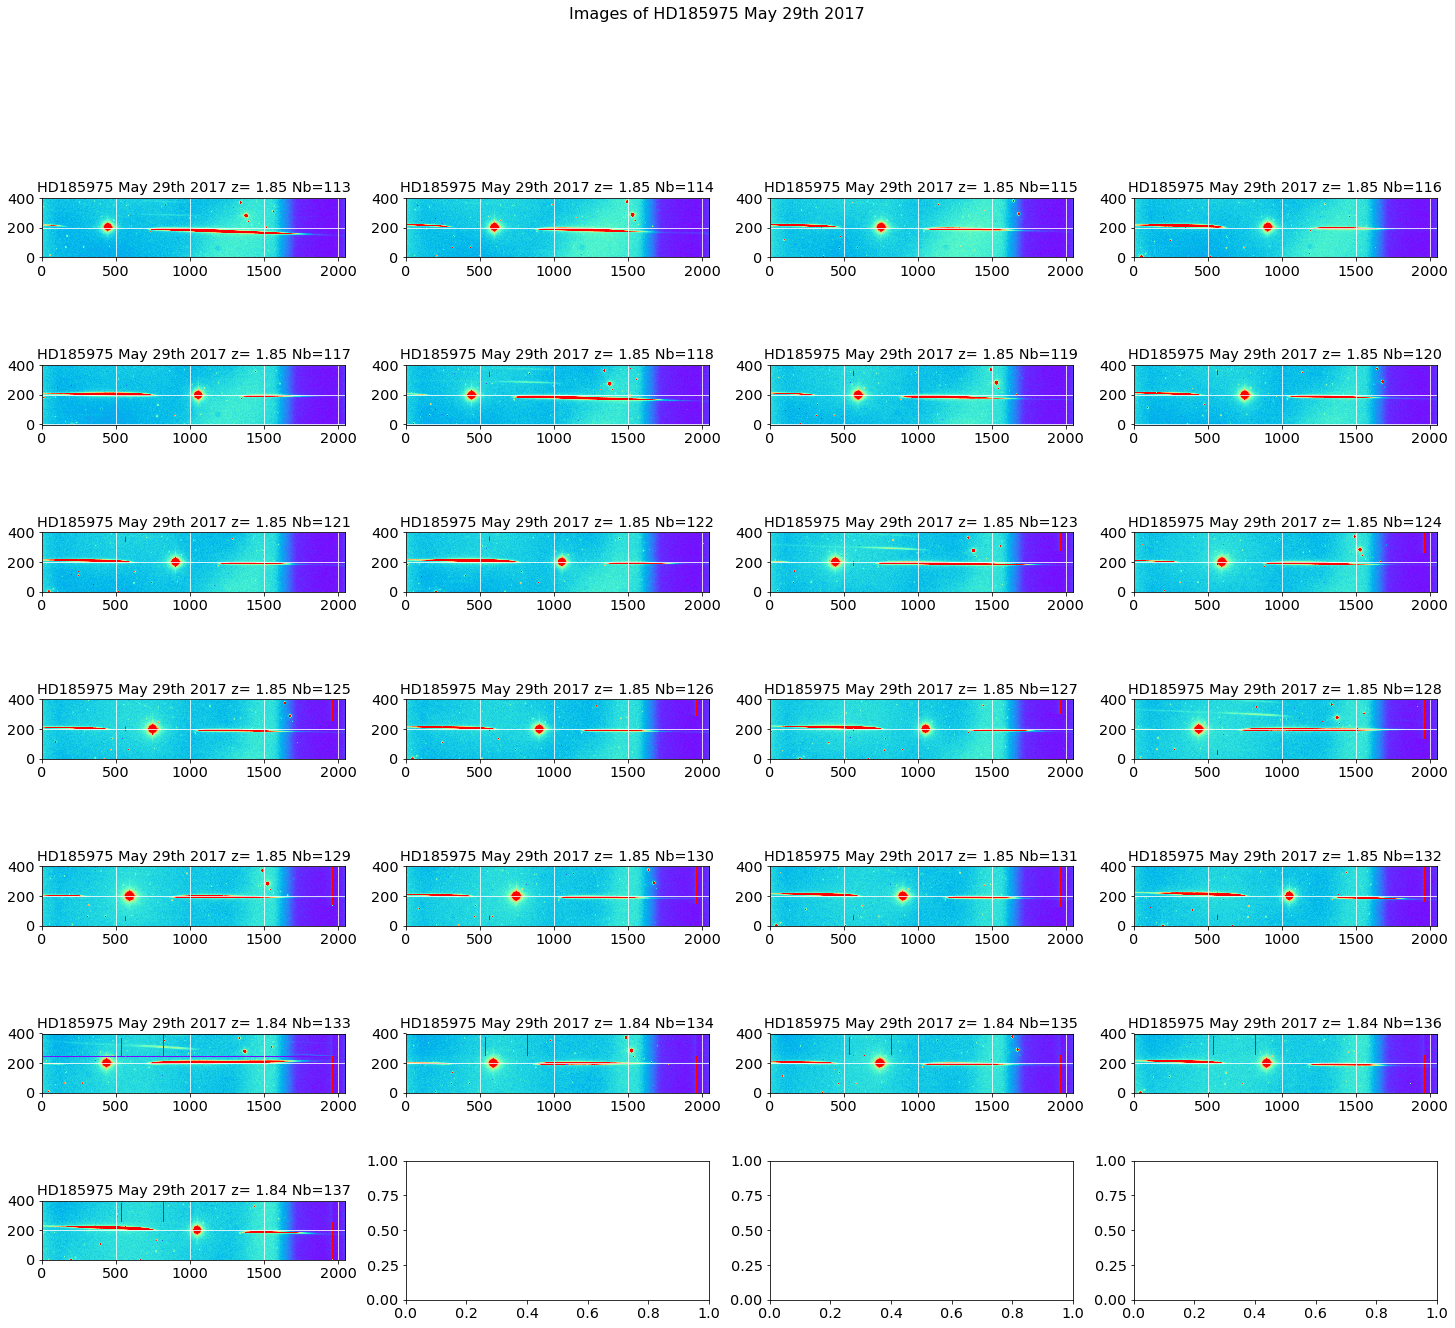

In [41]:
thex0=ShowImages(all_images,all_titles,object_name,dir_top_images)

## Duplicate the images

In [42]:
all_images2=[]
for image in all_images:
    image_copy=np.copy(image)
    all_images2.append(image_copy)


## Subtract Background

In [43]:
for theimage in all_images2:
    NR,NC=theimage.shape
    EmptySkyBackground=np.zeros([NR,NC])
    SkyBackground=EmptySkyBackground+np.median(theimage,axis=0)
    theimage-=SkyBackground

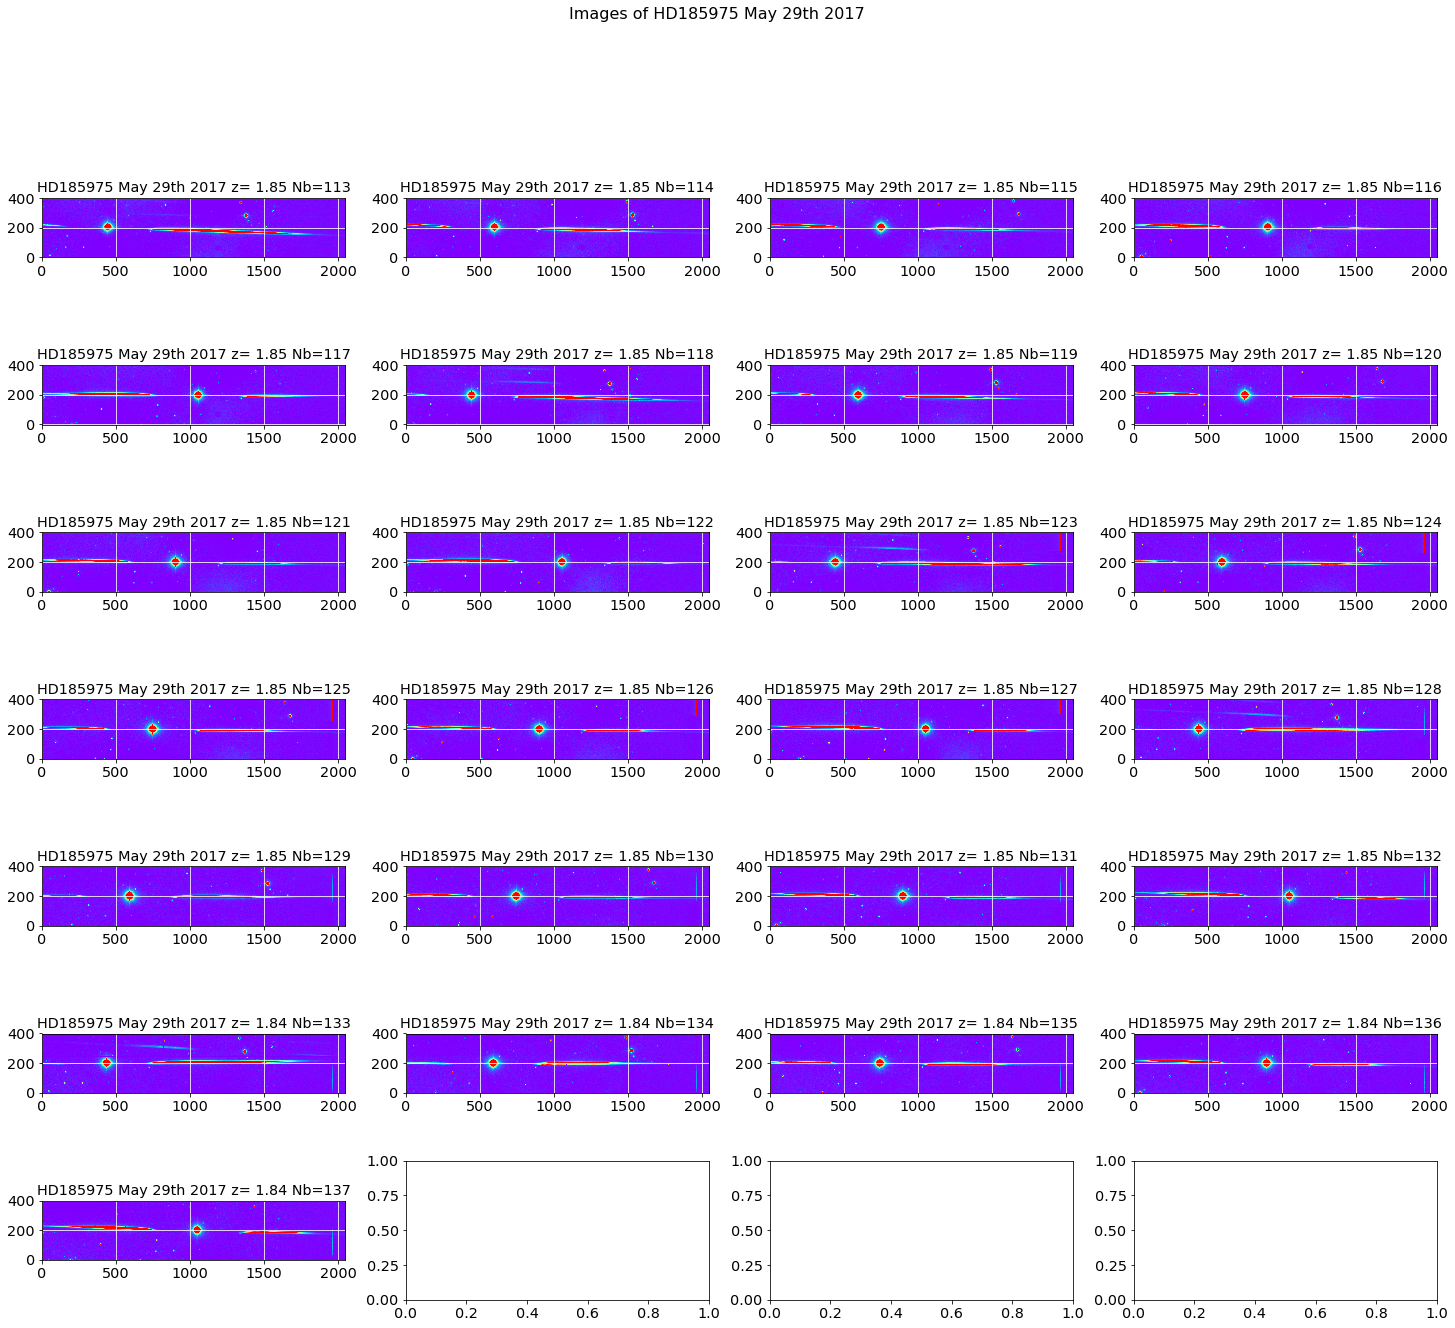

In [44]:
thex02=ShowImages(all_images2,all_titles,object_name,dir_top_images)

### Shows the transverse profile

In [45]:
DeltaX=600
w=20
ws=80

In [46]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
    
import os


def ShowTransverseProfile(all_images,all_titles,object_name,all_expo,dir_top_images):
    """
    ShowTransverseProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    DeltaX=600
    w=20
    ws=80
    thespectra= []
    they0= []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        data=np.copy(all_images[index])
        data[:,DeltaX-ws:DeltaX+ws]=0
        if(all_expo[index]<=0):
            yprofile=np.sum(data,axis=1)  #very special case
        else:
            yprofile=np.sum(data,axis=1)/all_expo[index]
        ymin=1
        ymax=yprofile.max()
        y0=np.where(yprofile==ymax)[0][0]
        they0.append(y0)
        #im=axarr[iy,ix].imshow(data,vmin=-10,vmax=50)
        axarr[iy,ix].semilogy(yprofile)
        axarr[iy,ix].semilogy([y0,y0],[ymin,ymax],'r-')
        axarr[iy,ix].semilogy([y0-w,y0-w],[ymin,ymax],'k-')
        axarr[iy,ix].semilogy([y0+w,y0+w],[ymin,ymax],'k-')
        axarr[iy,ix].set_ylim(1000.,2e5)
        spectrum2D=np.copy(data[y0-w:y0+w,:])
        xprofile=np.sum(spectrum2D,axis=0)
        thespectra.append(xprofile/(2.*float(w))/all_expo[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
    title='Spectrum tranverse profile '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'transverse_profile.pdf')
    plt.savefig(figfilename)  
    return thespectra,they0

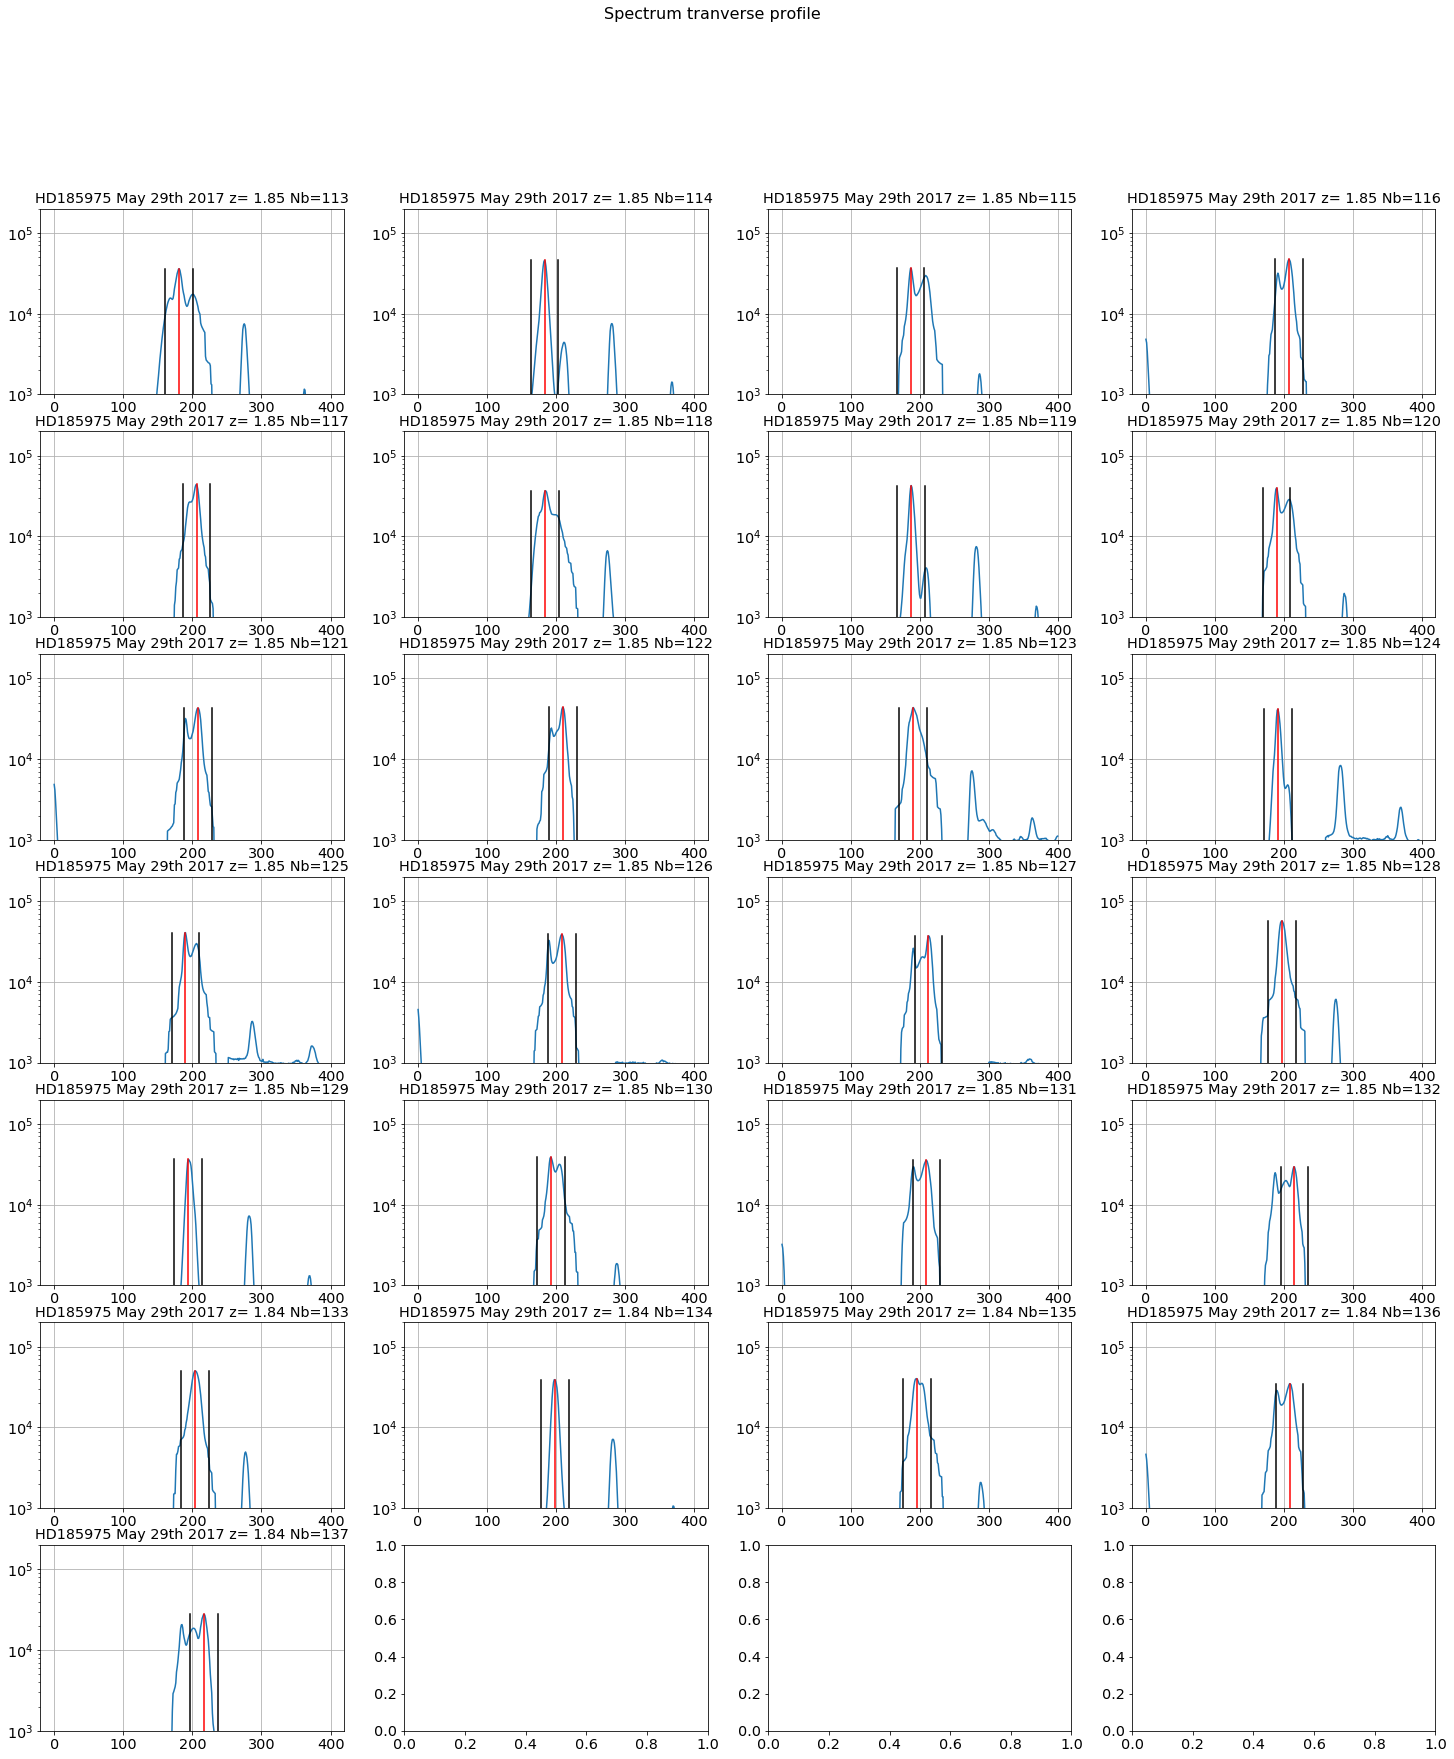

In [47]:
thespectra,they0=ShowTransverseProfile(all_images2,all_titles,object_name,all_expo,dir_top_images)

In [48]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import os
def ShowSpectrumProfile(spectra,all_titles,object_name,dir_top_images):
    """
    ShowSpectrumProfile: Show the raw images without background subtraction
    =====================
    """
    NBIMGPERROW=4
    NBSPEC=len(spectra)
    MAXIMGROW=int(NBSPEC/NBIMGPERROW)+1
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBSPEC):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        axarr[iy,ix].plot(spectra[index])
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,200.)
    title='Spectrum 1D profile '.format(object_name)
    figfilename=os.path.join(dir_top_images,'longitudinal_profile.pdf')
    plt.savefig(figfilename)  
    plt.suptitle(title,size=16)

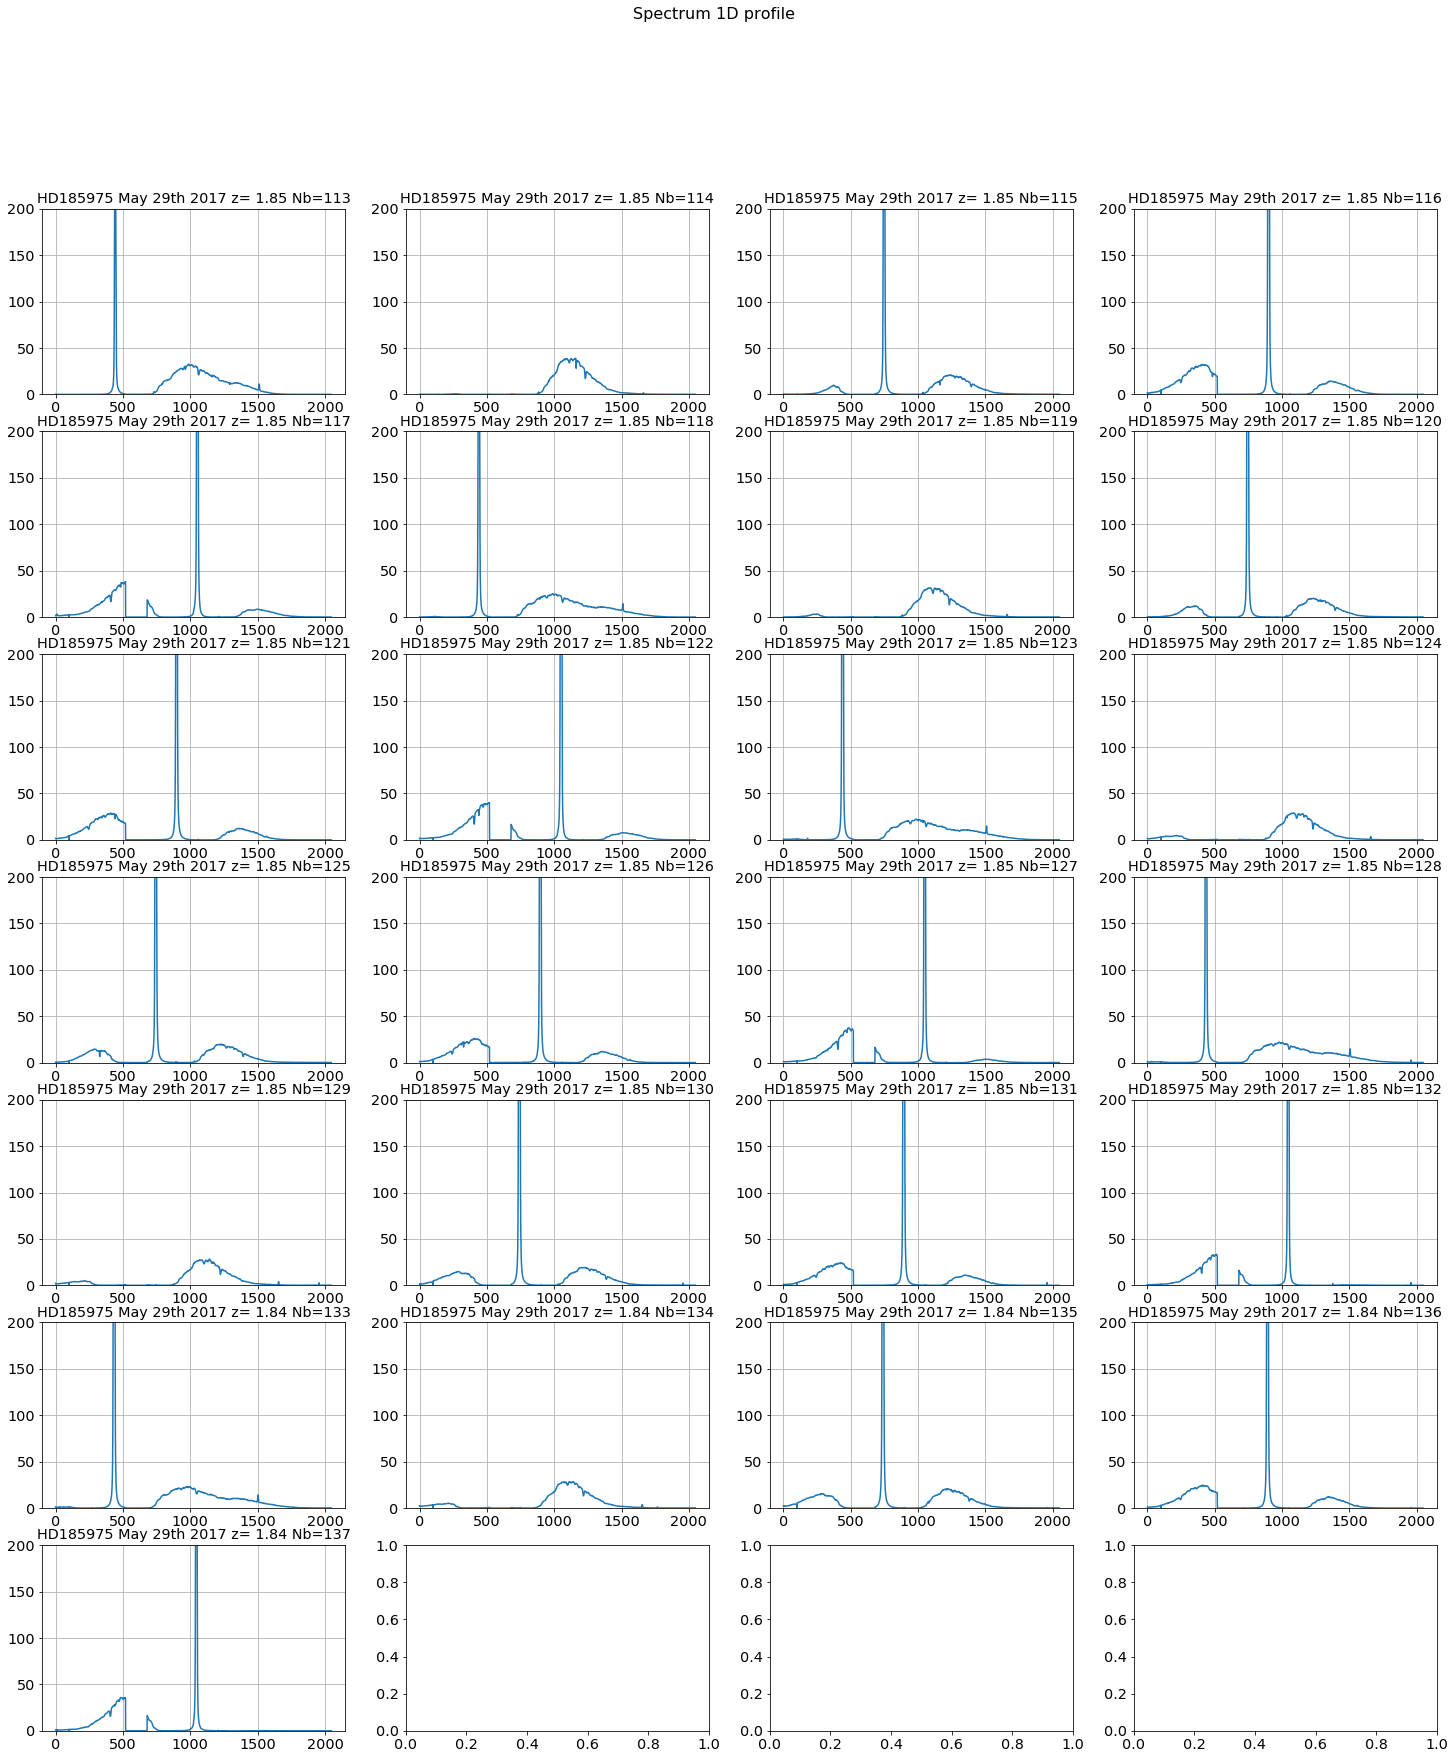

In [49]:
ShowSpectrumProfile(thespectra,all_titles,object_name,dir_top_images)

In [50]:
print they0

[181, 183, 186, 207, 206, 184, 187, 189, 208, 210, 190, 191, 190, 208, 212, 197, 194, 192, 209, 215, 204, 198, 195, 208, 217]


In [51]:
print thex0

[442, 594, 747, 900, 1053, 440, 593, 745, 898, 1051, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958, 1958]


### Test rotation optimum
----------------------------

In [52]:
from scipy import stats 
from scipy import ndimage
from scipy.optimize import curve_fit

In [53]:
sel=0

In [54]:
image_sel=np.copy(all_images2[sel])
y0=they0[sel]
x0=thex0[sel]

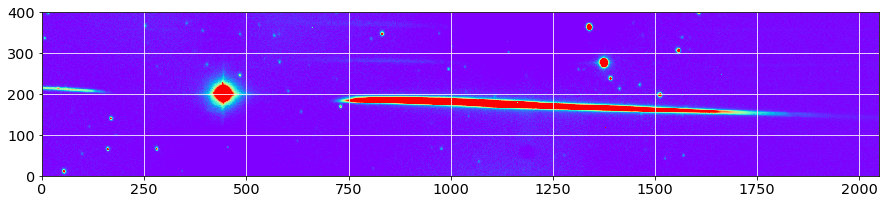

In [55]:
plt.imshow(image_sel,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')

In [56]:
region=np.copy(image_sel[y0-100:y0+100,:])
data=np.copy(region)

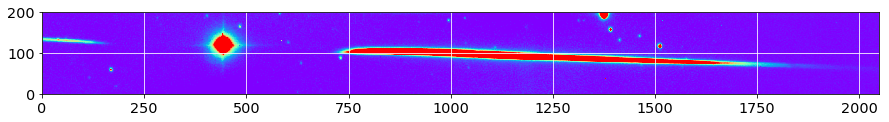

In [57]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')

### find the orientation by the average

In [58]:
def ComputeMedY(data):
    """
    Compute the median of Y vs X to find later the angle of rotation
    """
    NBINSY=data.shape[0]
    NBINSX=data.shape[1]
    the_medianY=np.zeros(NBINSX)
    the_y=np.zeros(NBINSY)
    for ix in np.arange(NBINSX):
        the_ysum=np.sum(data[:,ix])
        for iy in np.arange(NBINSY):
            the_y[iy]=iy*data[iy,ix]
        if(the_ysum>0):
            med=np.sum(the_y)/the_ysum
            the_medianY[ix]=med
    return the_medianY

In [59]:
def ComputeAveY(data):
    """
    Compute the average of Y vs X to find later the angle of rotation
    """
    NBINSY=data.shape[0]
    NBINSX=data.shape[1]
    the_averY=np.zeros(NBINSX)
    the_y=np.zeros(NBINSY)
    for ix in np.arange(NBINSX):
        the_ysum=np.sum(data[:,ix])
        for iy in np.arange(NBINSY):
            the_y[iy]=iy*data[iy,ix]
        if(the_ysum>0):
            med=np.sum(the_y)/the_ysum
            the_averY[ix]=med
    return the_averY

In [60]:

xindex=np.arange(data.shape[1])

In [61]:
#selected_indexes=np.where(np.logical_or(xindex<480,xindex>1100))

In [62]:
#selected_indexes=np.where(np.logical_or(np.logical_and(xindex>100,xindex<200) ,np.logical_and(xindex>1410,xindex<1600)))

In [63]:
selected_indexes=np.where(np.logical_or(np.logical_and(xindex>0,xindex<200) ,np.logical_and(xindex>750,xindex<1600)))

In [64]:
yaver=ComputeAveY(data)

In [65]:
XtoFit=np.array(xindex[selected_indexes])
YtoFit=np.array(yaver[selected_indexes])

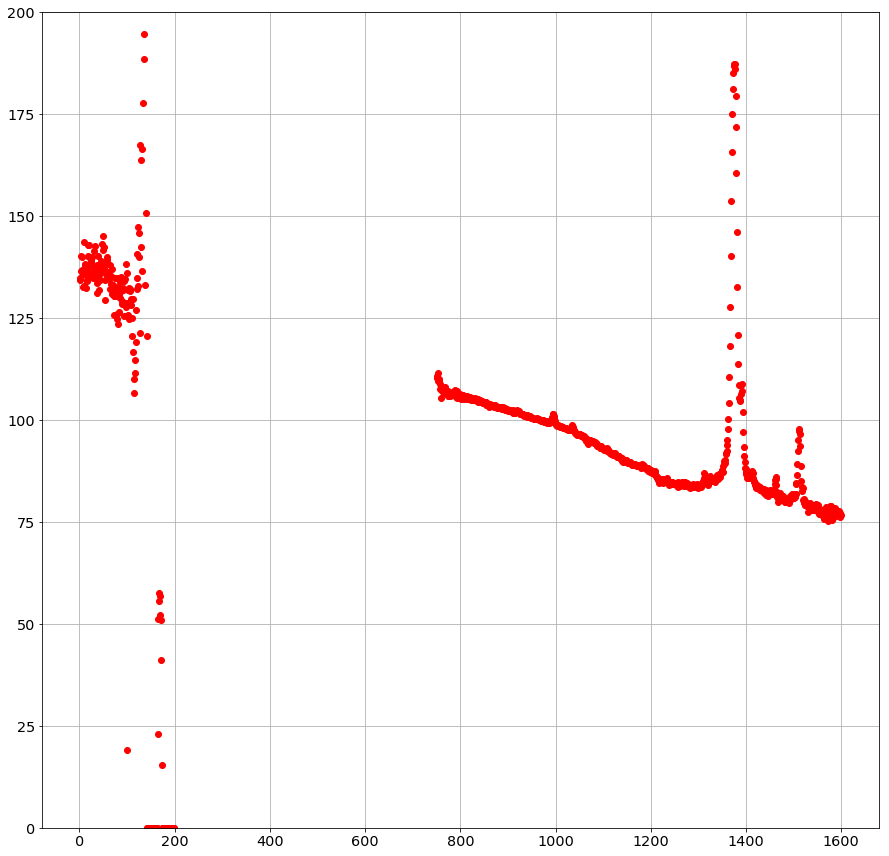

In [66]:
plt.plot(XtoFit,YtoFit,'ro')
plt.ylim(0,200)
plt.grid(True)

In [67]:
selected_indexes2=np.where(np.logical_and(YtoFit<200,YtoFit>0))

In [68]:
XtoFit2=XtoFit[selected_indexes2]
YtoFit2=YtoFit[selected_indexes2]

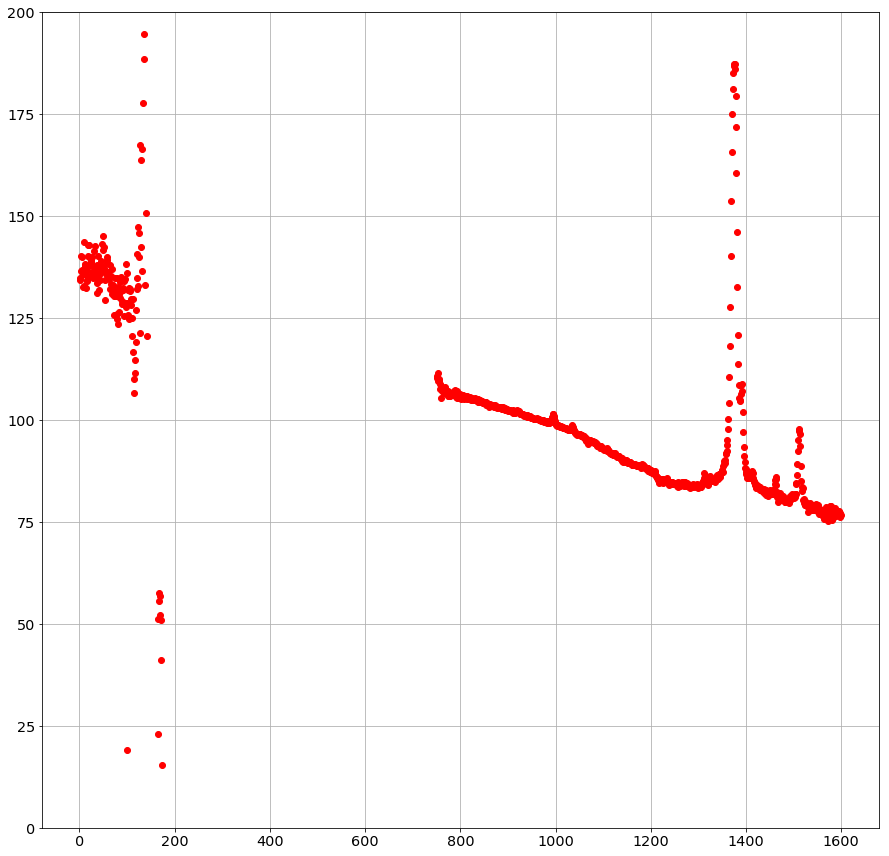

In [69]:
plt.plot(XtoFit2,YtoFit2,'ro')
plt.ylim(0,200)
plt.grid(True)

In [70]:
def fit_func(x, a, b):
    return a*x + b

In [71]:
from scipy.optimize import curve_fit
   

In [72]:
params = curve_fit(fit_func, XtoFit2, YtoFit2)
[a, b] = params[0]

In [73]:
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = fit_func(x_new,a,b)

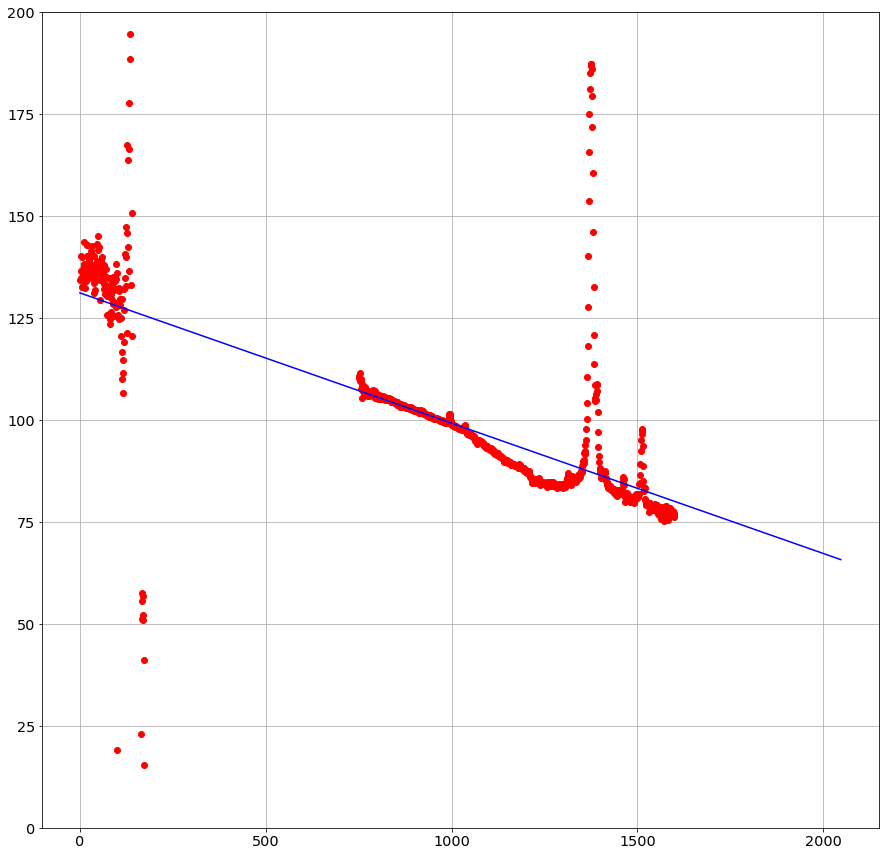

In [74]:
plt.plot(XtoFit2,YtoFit2,'ro')
plt.plot(x_new,y_new,'b-')
plt.ylim(0,200)
plt.grid(True)

In [75]:
print a,b

-0.031959856252 131.201763263


In [76]:
print np.arctan(a)*180/np.pi

-1.83054178852


### Find rotation by Hessian analysis

La méthode s'inspire des techniques de détection de filmanents dans le milieu interstellaire.
Elle est décrite dans https://arxiv.org/pdf/1409.6728.pdf section 4.1.
Documentation sur le calcul du Hessien : http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hessian_matrix

In [77]:
from skimage.feature import hessian_matrix
# le paramètre sigma permet de lisser le hessien
Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
print lambda_minus

[[-0.06737993 -0.06925397 -0.06225804 ...,  0.01366373  0.02144636
   0.02054866]
 [-0.06880087 -0.06895697 -0.05692005 ...,  0.02745559  0.03495412
   0.02971499]
 [-0.0586626  -0.05606781 -0.03594135 ...,  0.03541875  0.04482499
   0.03349067]
 ..., 
 [ 0.01297814  0.02843628  0.04599702 ...,  0.00881532  0.01082565
   0.00650212]
 [-0.00488003  0.0119192   0.03266567 ...,  0.00661541  0.00935521
   0.00648346]
 [-0.02219891 -0.00726273  0.01240613 ...,  0.00028517  0.00473144
   0.00400748]]


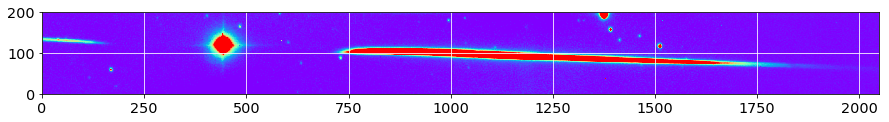

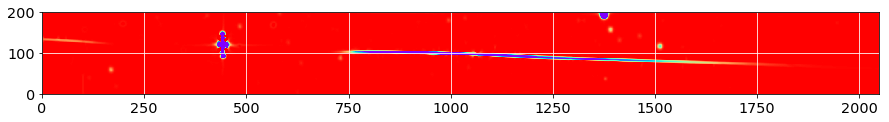

In [78]:
plt.imshow(data,origin='lower',cmap='rainbow',vmin=-10,vmax=800)
plt.grid(color='white', ls='solid')
plt.show()
plt.imshow(lambda_minus,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='white', ls='solid')
plt.show()

Maintenant on va sélectionner le spectre à l'aide d'un seuil pour éliminer le fond.

Number of remaining pixels : 6220


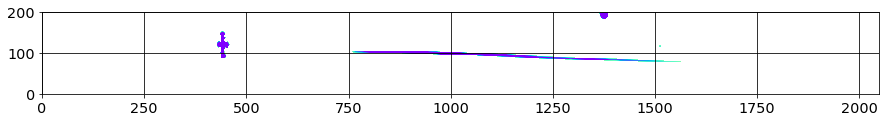

In [79]:
threshold = -50
mask = np.where(lambda_minus>threshold)
lambda_mask = np.copy(lambda_minus)
lambda_mask[mask]=np.nan
print 'Number of remaining pixels :',len(lambda_mask[~np.isnan(lambda_mask)])
plt.imshow(lambda_mask,origin='lower',cmap='rainbow',vmin=-100,vmax=0)
plt.grid(color='black', ls='solid')
plt.show()

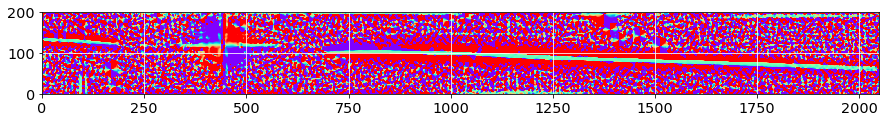

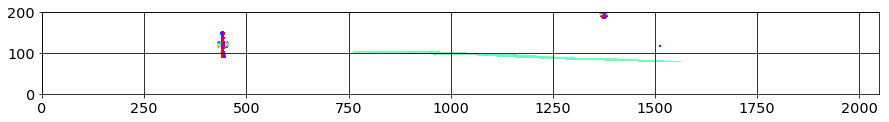

In [80]:
theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi
plt.imshow(theta,origin='lower',cmap='rainbow',vmin=-30,vmax=30)
plt.grid(color='white', ls='solid')
plt.show()
theta_mask = np.copy(theta)
theta_mask[mask]=np.nan
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-30,vmax=30)
plt.grid(color='black', ls='solid')
plt.show()

On sait que l'angle que l'on recherche est petit car l'axe de dispersion du réseau est bien aligné selon x, donc on peut sélectionner.

Number of remaining pixels : 5112


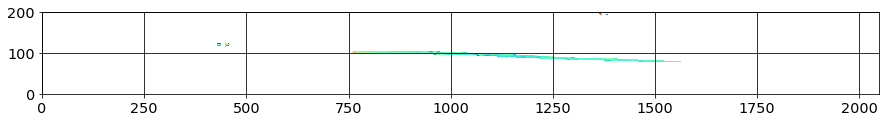

In [81]:
deg_threshold = 12
mask2 = np.where(np.abs(theta)>deg_threshold)
theta_mask[mask2] = np.nan
print 'Number of remaining pixels :',len(theta_mask[~np.isnan(theta_mask)])
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.grid(color='black', ls='solid')
plt.show()

Angle median : -1.8227543144


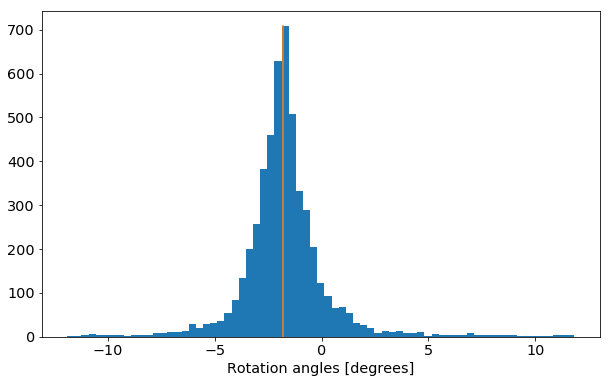

In [82]:
theta_hist = []
theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
theta_median = np.median(theta_hist)
print 'Angle median :',theta_median
fig = plt.figure(figsize=(10,6))
n,bins, patches = plt.hist(theta_hist,bins=int(np.sqrt(len(theta_hist))))
plt.plot([theta_median,theta_median],[0,np.max(n)])
plt.xlabel("Rotation angles [degrees]")
plt.show()

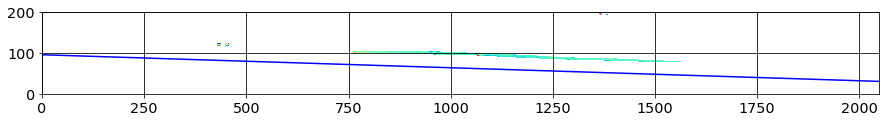

In [83]:
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = y0 -100 + (x_new-x0)*np.tan(theta_median*np.pi/180.)
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()

On peut aussi essayer de fitter le spectre qui a été détecté par la méthode ci-dessus.

Rotation angle from fit : -1.76001623323


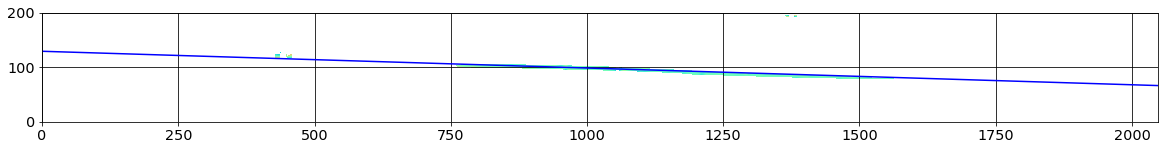

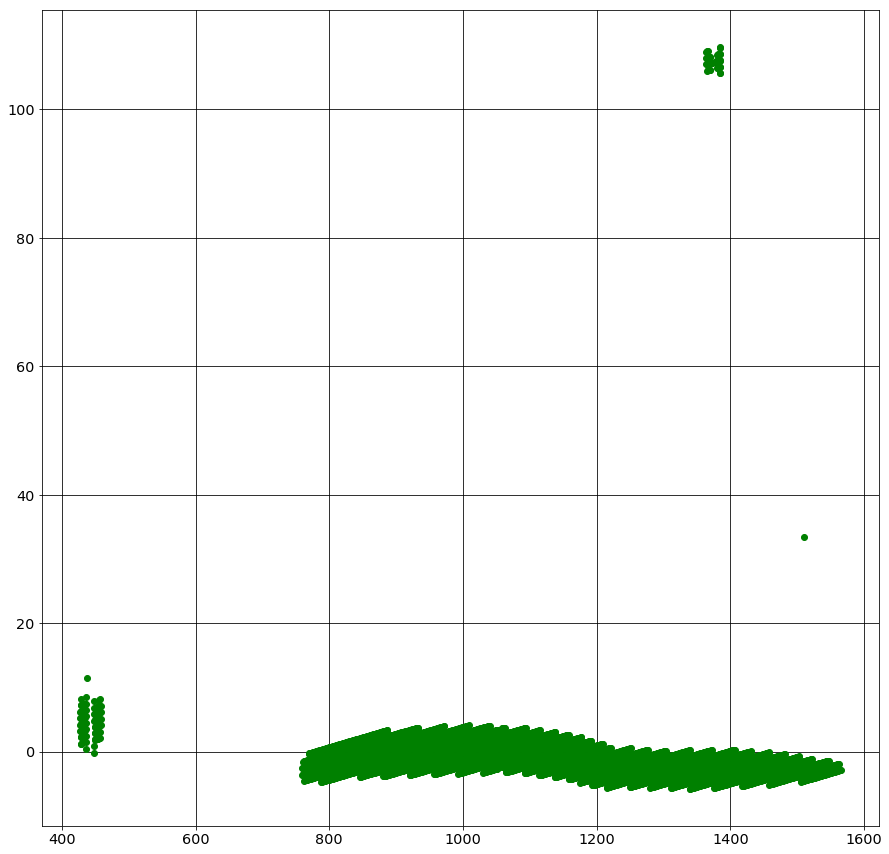

In [84]:
xtofit=[]
ytofit=[]
for iy,y in enumerate(theta_mask):
    for ix,x in enumerate(y):
        if not np.isnan(theta_mask[iy][ix]) :
            if np.abs(theta_mask[iy][ix])>12 : continue
            xtofit.append(ix)
            ytofit.append(iy)
params = curve_fit(fit_func, xtofit, ytofit)
[a, b] = params[0]
x_new = np.linspace(xindex.min(),xindex.max(), 50)
y_new = fit_func(x_new,a,b)
print 'Rotation angle from fit :',np.arctan(a)*180/np.pi
fig = plt.figure(figsize=[20,30])
plt.imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-30,vmax=30)
plt.plot(x_new,y_new,'b-')
plt.grid(color='black', ls='solid')
plt.show()
diff = []
for ix,x in enumerate(xtofit):
    diff.append(ytofit[ix]-fit_func(x,a,b))
plt.plot(xtofit,diff,'go')
plt.grid(color='black', ls='solid')
plt.show()

Je pense que la méthode de fit est plus compliquée dans un champ encombré.

## Find Rotation angle for each image
----------------------------------------------

In [85]:
def ComputeRotationAngle(all_images,thex0,they0,all_titles,object_name):
    """
    ComputeRotationAngle
    ====================
    
    input:
    ------
    all_images
    thex0
    they0
    
    
    output:
    ------
    param_a
    param_b
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    param_a=np.zeros(NBIMAGES)
    param_b=np.zeros(NBIMAGES)

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        
        image_sel=np.copy(image)
        y0=they0[index]
        x0=thex0[index]
        
        # extract a region of 200 x 1000 centered at y=100,x=500
        
        region=np.copy(image_sel[y0-100:y0+100,:])
        data=np.copy(region)
        
        xindex=np.arange(data.shape[1])
        
        #selected_indexes=np.where(np.logical_or(np.logical_and(xindex>100,xindex<200) ,np.logical_and(xindex>1410,xindex<1600))) 
        selected_indexes=np.where(np.logical_or(np.logical_and(xindex>0,xindex<150) ,np.logical_and(xindex>1500,xindex<1600)))
        # compute Y vs X
        yaver=ComputeAveY(data)
        
        XtoFit=xindex[selected_indexes]
        YtoFit=yaver[selected_indexes]
        # does the fit
        params = curve_fit(fit_func, XtoFit, YtoFit)
        [a, b] = params[0]
        
        param_a[index]=a
        param_b[index]=b
        
        print index,' y = ',a,' * x + ',b
        x_new = np.linspace(xindex.min(),xindex.max(), 50)
        y_new = fit_func(x_new,a,b)
    
        im=axarr[iy,ix].plot(XtoFit,YtoFit,'ro')
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].set_ylim(0,200)
        axarr[iy,ix].grid(True)
        
    title='Fit rotation angle of '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
    plt.savefig(figfilename)  
    
    
    return param_a,param_b
    
    

0  y =  -0.0501742594127  * x +  159.222762924
1  y =  -0.00220010910758  * x +  131.766523202
2  y =  -0.0213313601454  * x +  127.155324923
3  y =  -0.0149468216226  * x +  105.308569664
4  y =  -0.00624500150682  * x +  98.7231660981
5  y =  -0.0407356889215  * x +  151.265201512
6  y =  0.00135637949161  * x +  130.290866801
7  y =  -0.0197526150403  * x +  125.100731079
8  y =  -0.0186872481736  * x +  108.685595078
9  y =  -0.0154000628732  * x +  106.705670595
10  y =  -0.00859686400734  * x +  107.473325999
11  y =  0.0132781759746  * x +  115.098543086
12  y =  -0.0147160765608  * x +  119.088015317
13  y =  -0.0158333703126  * x +  103.847188624
14  y =  -0.0138633021445  * x +  100.265758875
15  y =  0.00846809734219  * x +  85.3461457726
16  y =  0.0189255160667  * x +  106.388507217
17  y =  -0.0113141946366  * x +  114.12180798
18  y =  -0.0156342773533  * x +  103.029531006
19  y =  -0.0156623991377  * x +  97.1742641821
20  y =  0.0570004726766  * x +  15.0775325545
21 

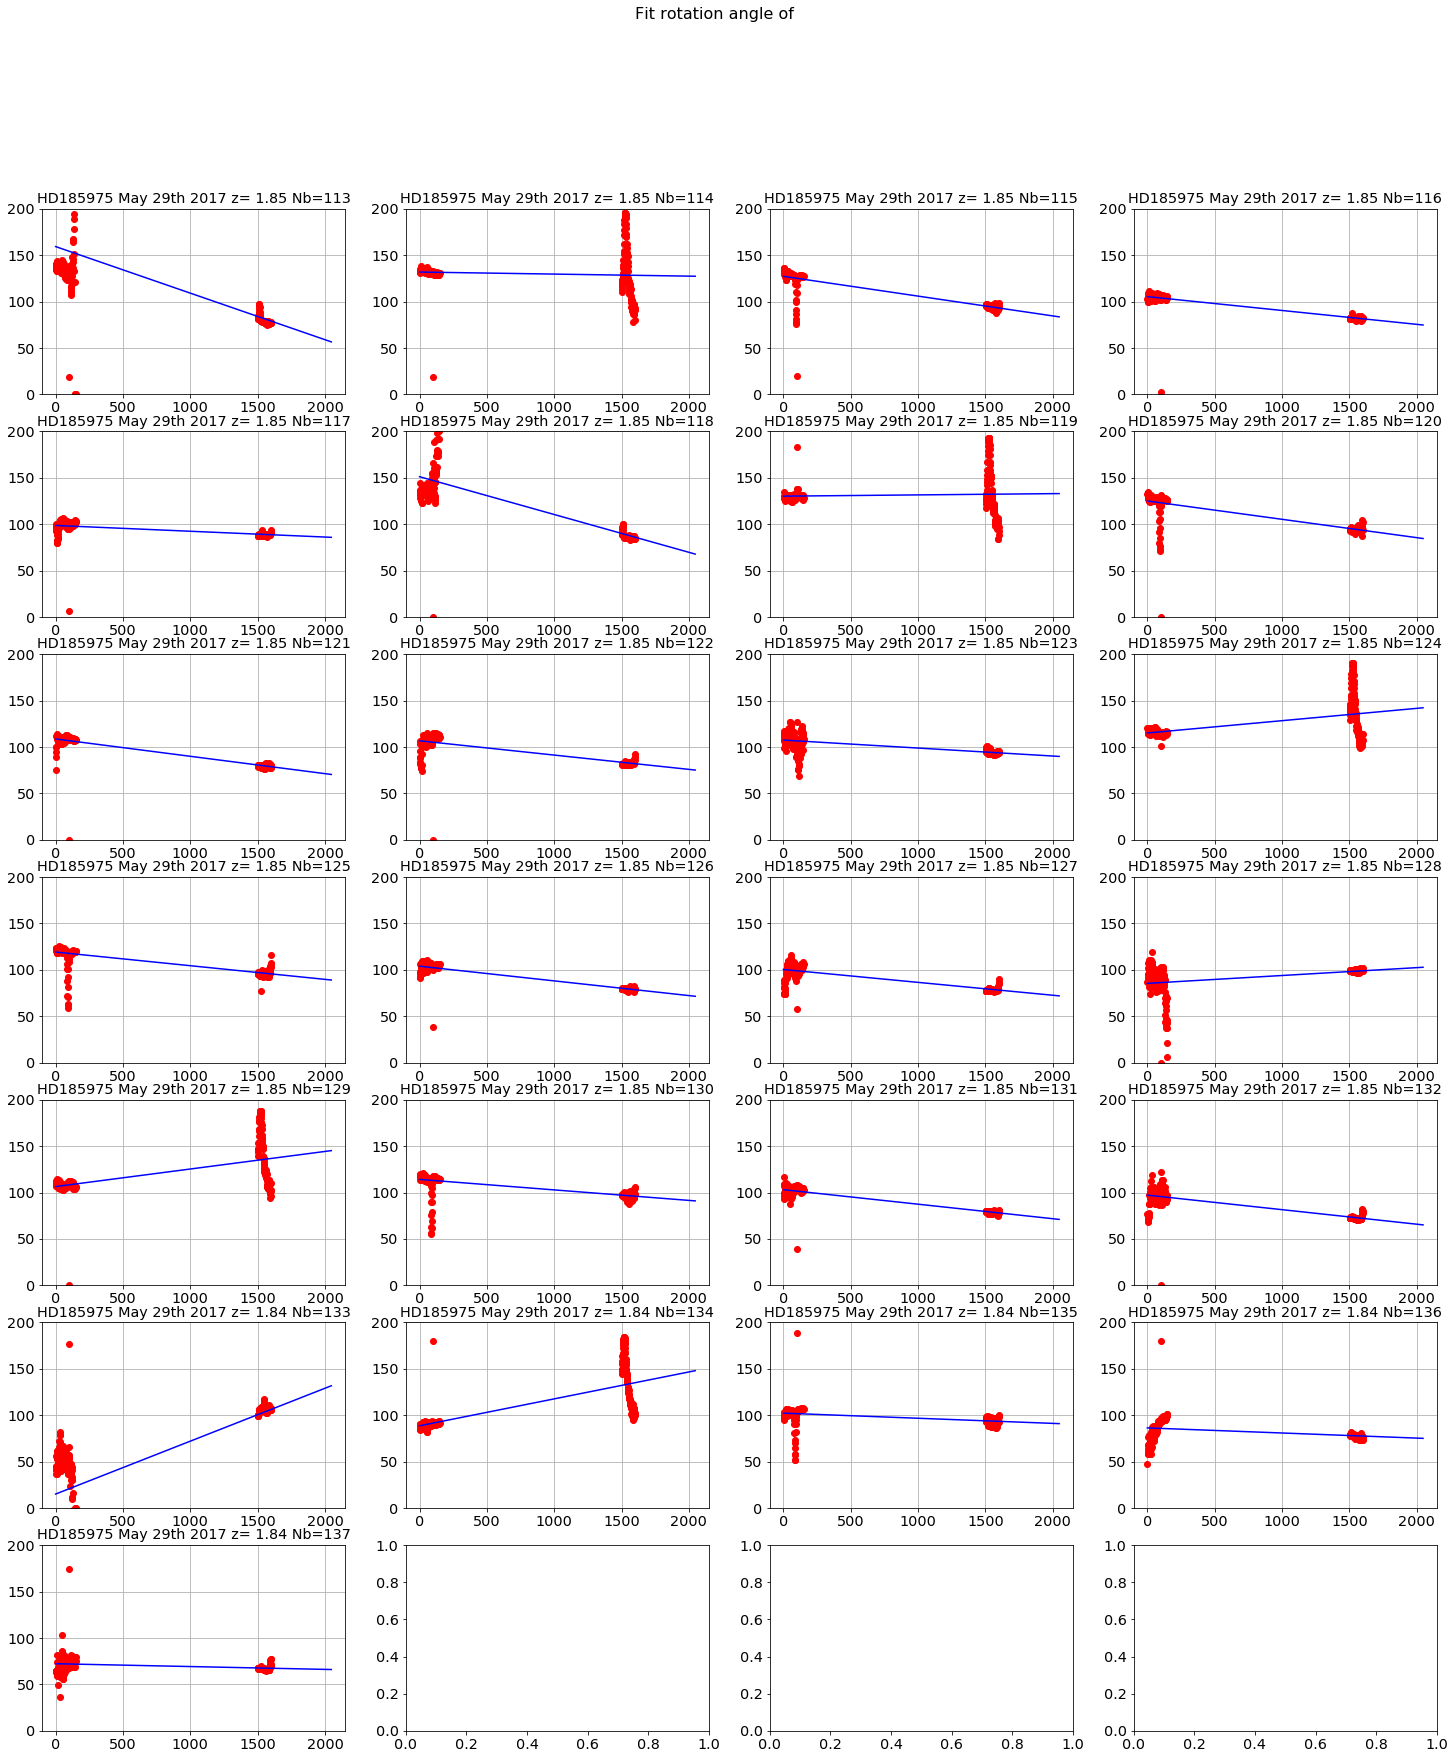

In [86]:
all_a,all_b=ComputeRotationAngle(all_images2,thex0,they0,all_titles,object_name)

In [87]:
all_angles=np.arctan(all_a)*180./np.pi

In [88]:
textfilename = os.path.join(inputdir,'star_centroids.txt')
central_positions = np.loadtxt(textfilename)

def ComputeRotationAngleHessian(all_images,thex0,they0,all_titles,object_name):
    """
    ComputeRotationAngle
    ====================
    
    input:
    ------
    all_images
    thex0
    they0
    
    
    output:
    ------
    param_a
    param_b
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    param_theta=np.zeros(NBIMAGES)
    
    lambda_threshold = -50
    deg_threshold = 12

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        
        image_sel=np.copy(image)
        y0=they0[index]
        x0=thex0[index]
        
        # extract a region of 200 x 1000 centered at y=100,x=500
        
        region=np.copy(image_sel[y0-100:y0+100,:])
        data=np.copy(region)
        
        # compute hessian matrices on the image
        
        Hxx, Hxy, Hyy = hessian_matrix(data, sigma=3, order = 'xy')
        lambda_plus = 0.5*( (Hxx+Hyy) + np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
        lambda_minus = 0.5*( (Hxx+Hyy) - np.sqrt( (Hxx-Hyy)**2 +4*Hxy*Hxy) )
                

        mask = np.where(lambda_minus>lambda_threshold)
        #lambda_mask = np.copy(lambda_minus)
        #lambda_mask[mask]=np.nan

        theta = 0.5*np.arctan2(2*Hxy,Hyy-Hxx)*180/np.pi
        theta_mask = np.copy(theta)
        theta_mask[mask]=np.nan

        mask2 = np.where(np.abs(theta)>deg_threshold)
        theta_mask[mask2] = np.nan
        
        theta_hist = []
        theta_hist = theta_mask[~np.isnan(theta_mask)].flatten()
        theta_median = np.median(theta_hist)
        
        param_theta[index] = theta_median
        
        print index,' theta = ',theta_median, '\tx0 = ',central_positions[index][1], '\ty0 = ',central_positions[index][0]
        x_new = np.linspace(xindex.min(),xindex.max(), 50)
        y_new = y0 -100 + (x_new-x0)*np.tan(theta_median*np.pi/180.)
    
        im=axarr[iy,ix].imshow(theta_mask,origin='lower',cmap='rainbow',vmin=-deg_threshold,vmax=deg_threshold)
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        
        axarr[iy,ix].set_ylim(0,200)
        axarr[iy,ix].grid(True)
        

    title='Fit rotation angle of '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'fit_rotation.pdf')
    plt.savefig(figfilename)  
    
    
    return param_theta
    

[-2.87236457 -0.12605676 -1.22201158 -0.85632603 -0.35780758 -2.33269333
  0.07771477 -1.13159432 -1.07057584 -0.88228886 -0.49255189  0.76073874
 -0.84310822 -0.9071095  -0.79425782  0.48517464  1.08422276 -0.64822794
 -0.89570513 -0.897316    3.26235638  1.66179425 -0.31633637 -0.31500858
 -0.17464807]
0  theta =  -1.8227543144 	x0 =  442.0 	y0 =  387.0
1  theta =  -1.39809960041 	x0 =  594.0 	y0 =  383.0
2  theta =  -1.31232490231 	x0 =  747.0 	y0 =  379.0
3  theta =  -0.923584469791 	x0 =  900.0 	y0 =  377.0
4  theta =  -0.682727176673 	x0 =  1052.0 	y0 =  375.0
5  theta =  -1.19690428195 	x0 =  440.0 	y0 =  536.0
6  theta =  -1.00120855884 	x0 =  592.0 	y0 =  530.0
7  theta =  -1.14952738377 	x0 =  745.0 	y0 =  526.0
8  theta =  -0.947663081979 	x0 =  898.0 	y0 =  524.0
9  theta =  -0.87774745935 	x0 =  1050.0 	y0 =  521.0
10  theta =  -0.525468832971 	x0 =  438.0 	y0 =  684.0
11  theta =  -0.64976637146 	x0 =  591.0 	y0 =  678.0
12  theta =  -0.91733107001 	x0 =  743.0 	y0 =  675

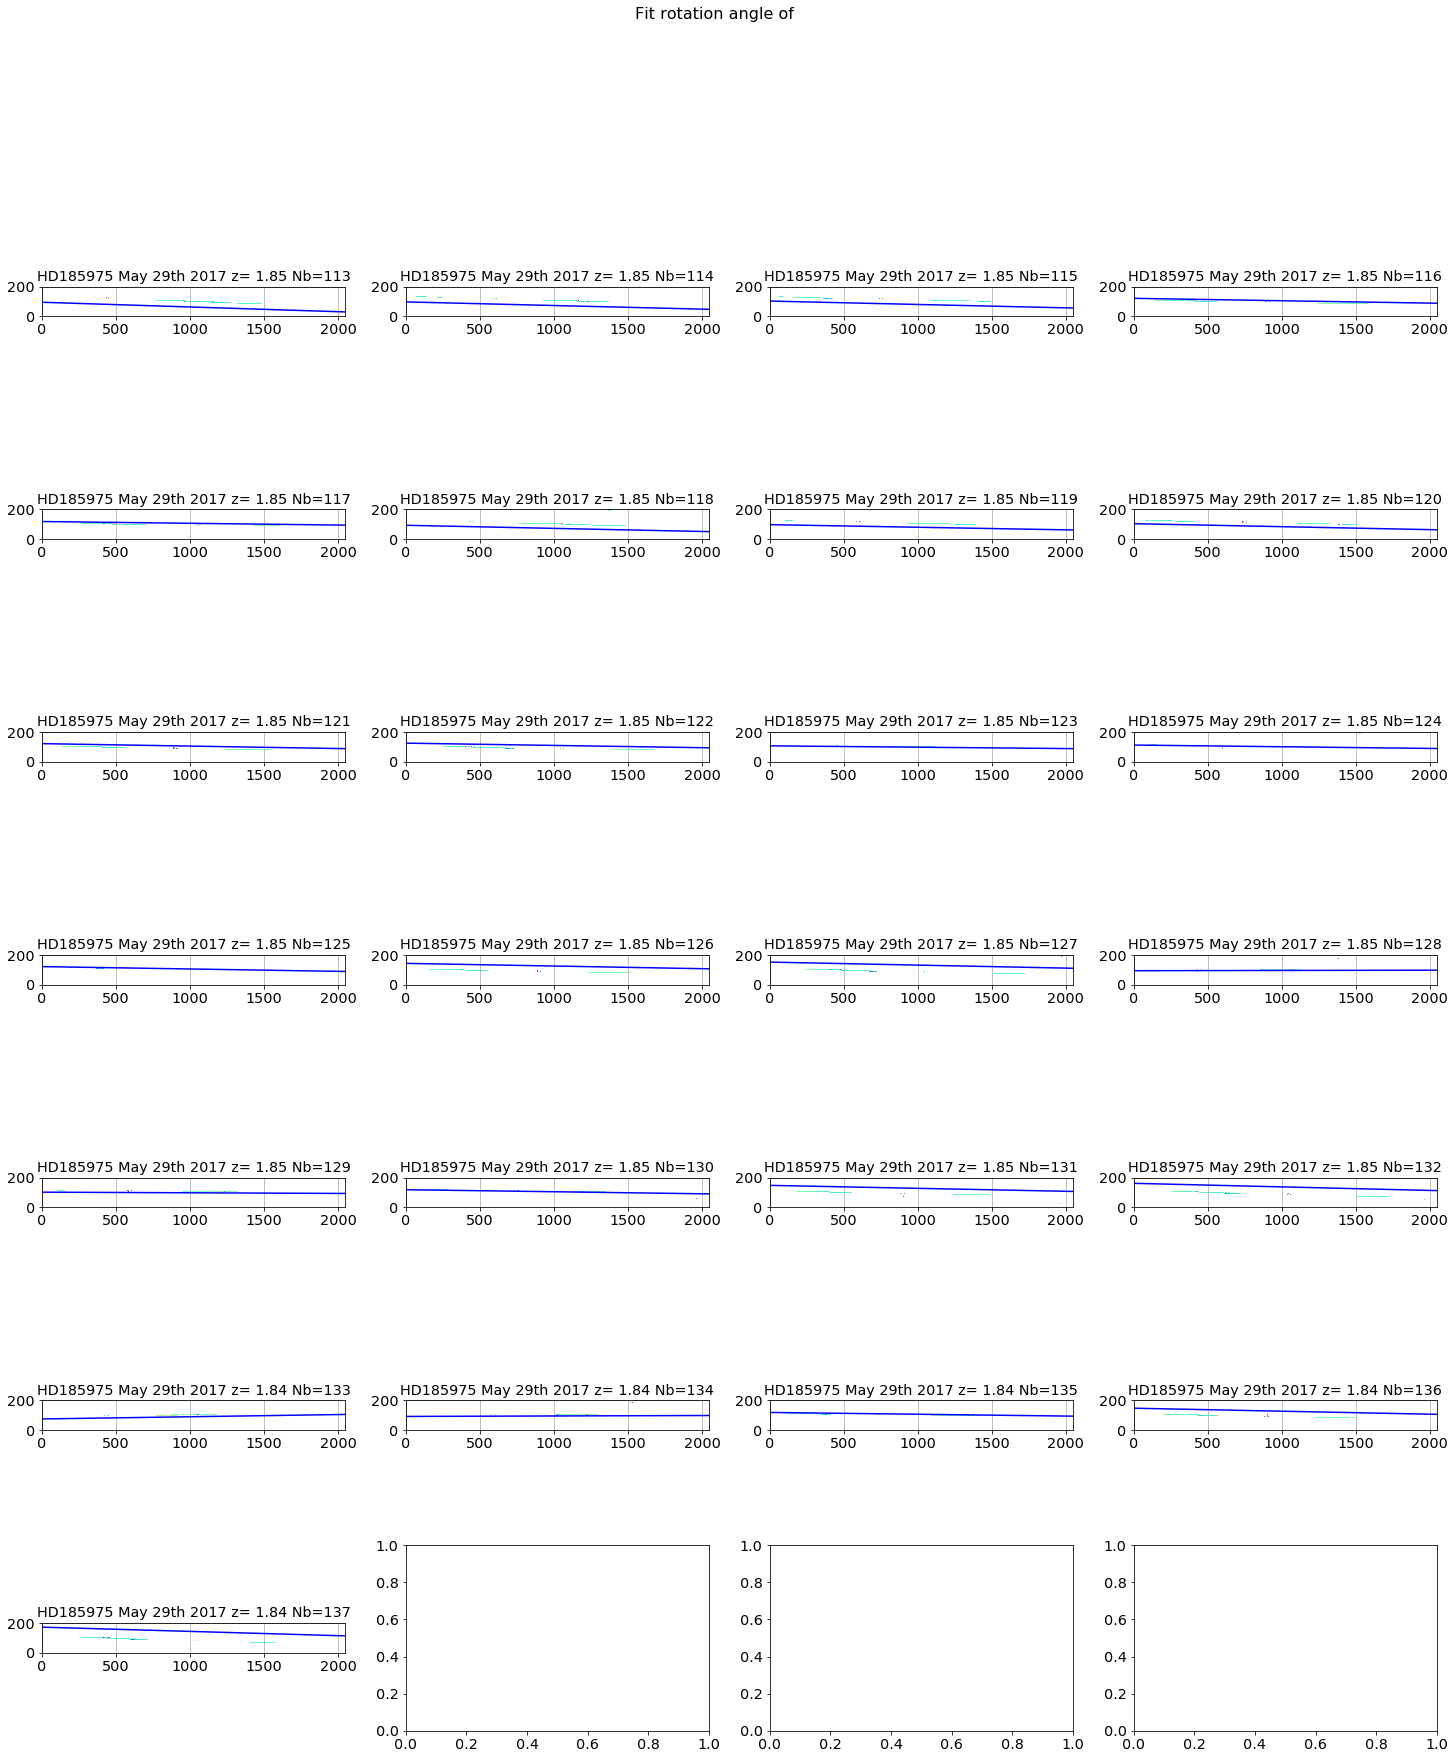

In [89]:
print all_angles
all_theta=ComputeRotationAngleHessian(all_images2,thex0,they0,all_titles,object_name)

### Choose here which rotation angle to apply

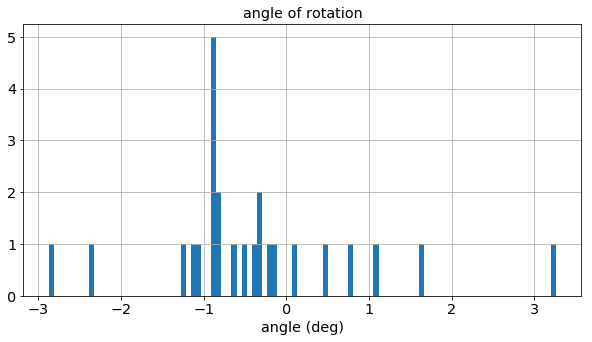

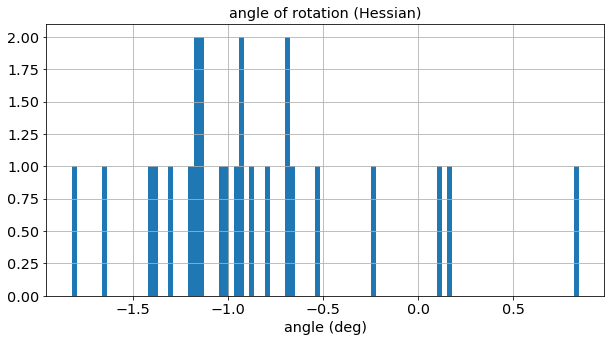

In [90]:
plt.figure(figsize=(10,5))
#hist(x, bins=10, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)
#n, bins, patches=plt.hist(all_angles,bins=50,range=[-1,.5],histtype='stepfilled')
n, bins, patches=plt.hist(all_angles,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation')
plt.xlabel('angle (deg)')
plt.figure(figsize=(10,5))
#hist(x, bins=10, range=None, normed=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, hold=None, data=None, **kwargs)
#n, bins, patches=plt.hist(all_angles,bins=50,range=[-1,.5],histtype='stepfilled')
n, bins, patches=plt.hist(all_theta,bins=100,histtype='stepfilled')
plt.grid(True)
plt.title('angle of rotation (Hessian)')
plt.xlabel('angle (deg)')

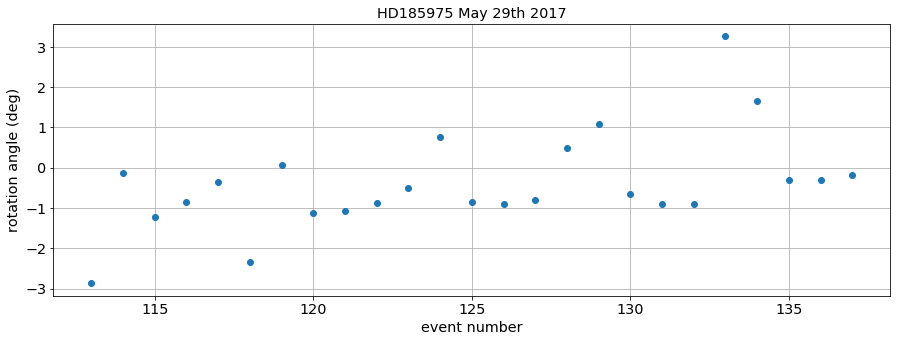

In [91]:
plt.figure(figsize=(15,5))
plt.plot(indexes_files,all_angles,'o')
plt.grid(True)
plt.ylabel('rotation angle (deg)')
plt.xlabel('event number')
plt.title(object_name)
figfilename=os.path.join(dir_top_images,'rotationvsevnum.pdf')
plt.savefig(figfilename) 

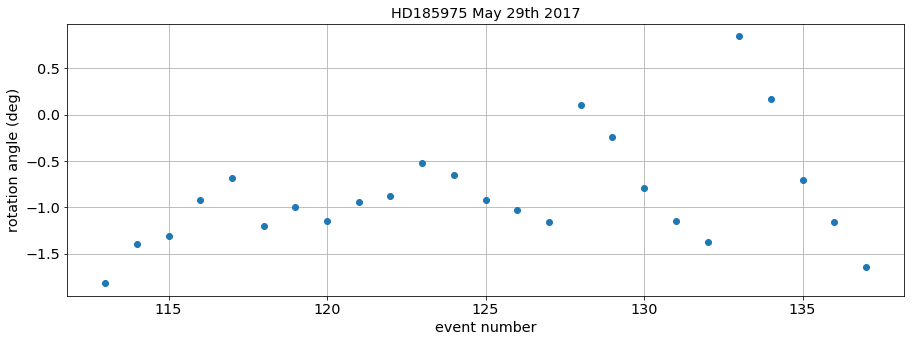

In [92]:
plt.figure(figsize=(15,5))
plt.plot(indexes_files,all_theta,'o')
plt.grid(True)
plt.ylabel('rotation angle (deg)')
plt.xlabel('event number')
plt.title(object_name)
figfilename=os.path.join(dir_top_images,'rotationvsevnum_hessian.pdf')
plt.savefig(figfilename) 

Avec la méthode Hessienne, on voit qu'on obtient des séries de 5 points : une première qui monte, une deuxième plate (donc la bonne hauteur de l'image en y ?) et trois descendantes.

## Now turn the images accordingly

In [93]:
def TurnTheImages(all_images,all_angles,all_titles,object_name,dir_top_images):
    """
    TurnTheImages
    =============
    
    input:
    ------
    all_images:
    all_angles:
    
    
    output:
    ------
    all_rotated_images
    
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERROW)+1
    
    all_rotated_images = []

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERROW,figsize=(25,4*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERROW
        iy=index/NBIMGPERROW
        
        image=all_images[index]    
        angle=all_angles[index]    
        data=np.copy(image)
        
        rotated_image=ndimage.interpolation.rotate(data,angle)
        
        all_rotated_images.append(rotated_image)
        
        im=axarr[iy,ix].imshow(rotated_image,origin='lower',cmap='rainbow',vmin=0,vmax=800)
        im=axarr[iy,ix].plot(x_new,y_new,'b-')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        
        axarr[iy,ix].grid(True)
        
    title='Rotated images for '.format(object_name)    
    plt.suptitle(title,size=16)
    
    figfilename=os.path.join(dir_top_images,'rotated_images.pdf')
    plt.savefig(figfilename)  
    
    return all_rotated_images

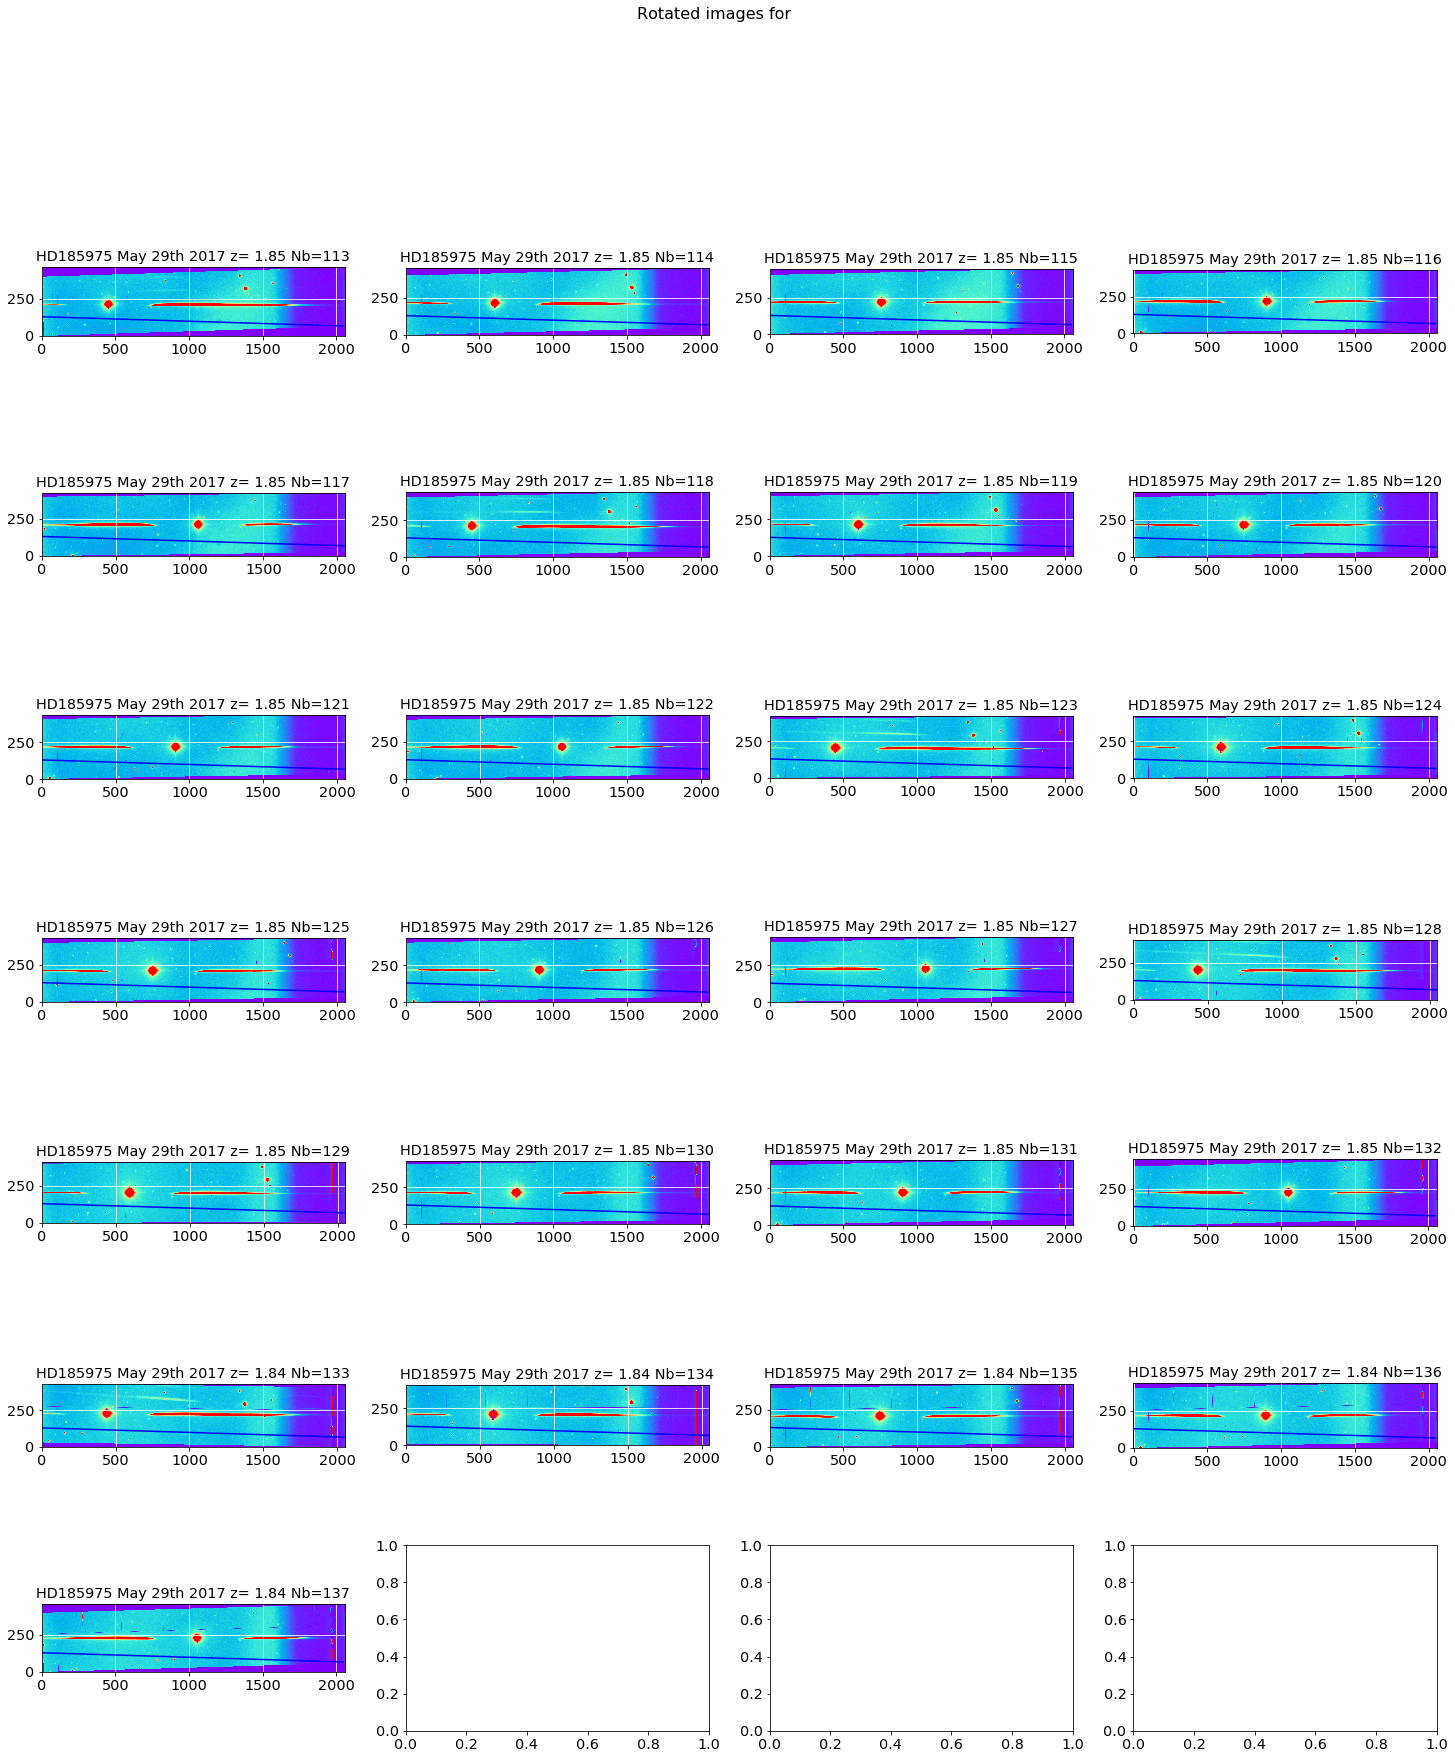

In [94]:
# J'utilise les angles qui viennent de la méthode Hessienne ici
turned_images=TurnTheImages(all_images,all_theta,all_titles,object_name,dir_top_images) #same rotation for each image

## Check rotation

In case of bad rotation, check by eye

In [95]:
sel=4

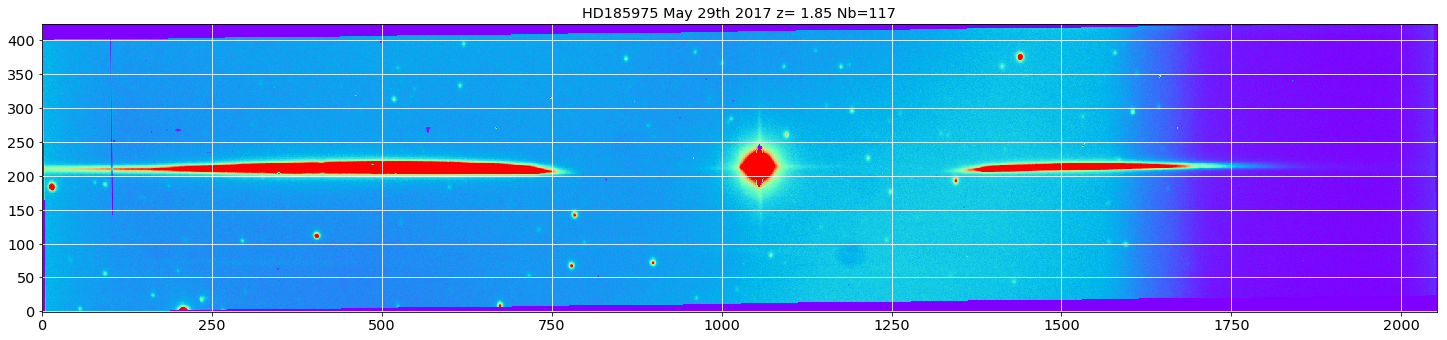

In [96]:
plt.figure(figsize=(25,10))
plt.imshow(turned_images[sel],origin='lower',cmap='rainbow',vmin=0,vmax=1000)
plt.grid(True)
plt.title(all_titles[sel])
plt.grid(color='white', ls='solid')
figfilename=os.path.join(dir_top_images,'rotated_image_sample.pdf')
plt.savefig(figfilename)  

In [97]:
image_sel=np.copy(turned_images[sel])
y0=they0[sel]
x0=thex0[sel]

In [98]:
region=np.copy(image_sel[y0-100:y0+100,:])
data=np.copy(region)

0  theta =  0.0359415244246 	x0 =  442.0 	y0 =  387.0
1  theta =  0.0118031518143 	x0 =  594.0 	y0 =  383.0
2  theta =  0.029575709413 	x0 =  747.0 	y0 =  379.0
3  theta =  0.031555499026 	x0 =  900.0 	y0 =  377.0
4  theta =  0.0129547975631 	x0 =  1052.0 	y0 =  375.0
5  theta =  0.0246326566091 	x0 =  440.0 	y0 =  536.0
6  theta =  0.0222393663643 	x0 =  592.0 	y0 =  530.0
7  theta =  0.0356868497232 	x0 =  745.0 	y0 =  526.0
8  theta =  -0.02347498486 	x0 =  898.0 	y0 =  524.0
9  theta =  0.0207878448007 	x0 =  1050.0 	y0 =  521.0
10  theta =  -0.00316525474117 	x0 =  438.0 	y0 =  684.0
11  theta =  0.025744285302 	x0 =  591.0 	y0 =  678.0
12  theta =  0.0395326455254 	x0 =  743.0 	y0 =  675.0
13  theta =  0.02255969411 	x0 =  896.0 	y0 =  672.0
14  theta =  0.00743826456766 	x0 =  1048.0 	y0 =  670.0
15  theta =  -0.012672204889 	x0 =  435.0 	y0 =  831.0
16  theta =  0.00245236897687 	x0 =  588.0 	y0 =  825.0
17  theta =  0.0249746697312 	x0 =  740.0 	y0 =  822.0
18  theta =  0.0120

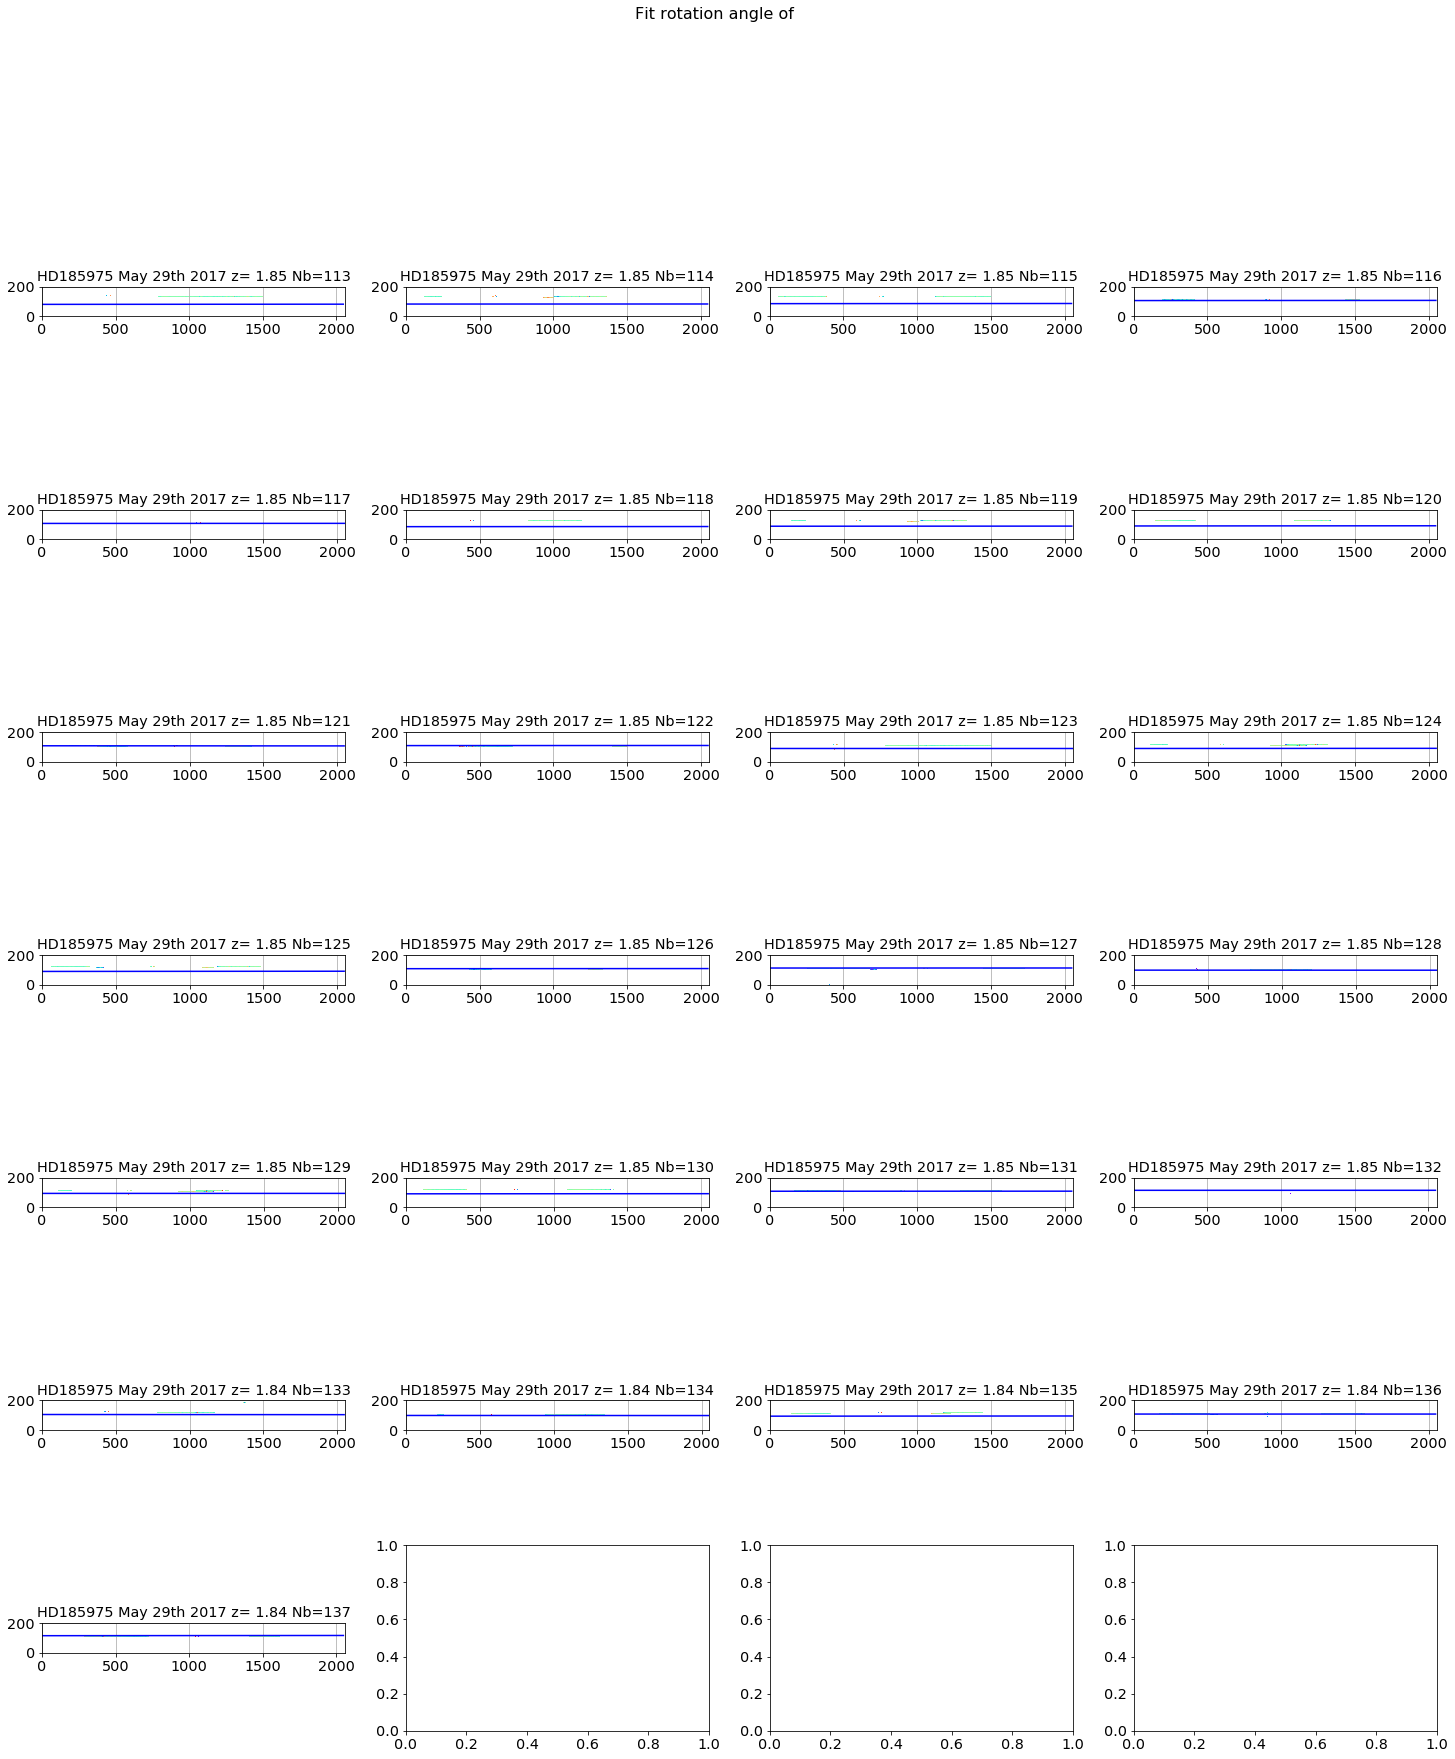

In [100]:
theta = ComputeRotationAngleHessian(turned_images,thex0,they0,all_titles,object_name)

## Analyse angles to find hologram center

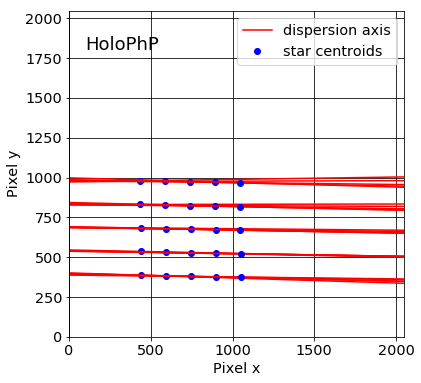

In [117]:
IMSIZE=2048
fig=plt.figure(figsize=(6,6))

for index in np.arange(len(all_theta)):
    y0=central_positions[index][0]
    x0=central_positions[index][1]
    x_new = np.linspace(0,IMSIZE, 50)
    y_new = y0 + (x_new-x0)*np.tan(all_theta[index]*np.pi/180.)
    if index==0 :
        plt.plot(x_new,y_new,'r-',label='dispersion axis')
        plt.plot(x0,y0,'bo',label='star centroids')
    else :
        plt.plot(x_new,y_new,'r-')
        plt.plot(x0,y0,'bo')
plt.xlim([0,IMSIZE])
plt.ylim([0,IMSIZE])
plt.grid(color='black', ls='solid')
plt.xlabel('Pixel x')
plt.ylabel('Pixel y')
plt.text(100,1800,holo_name,fontsize=18)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


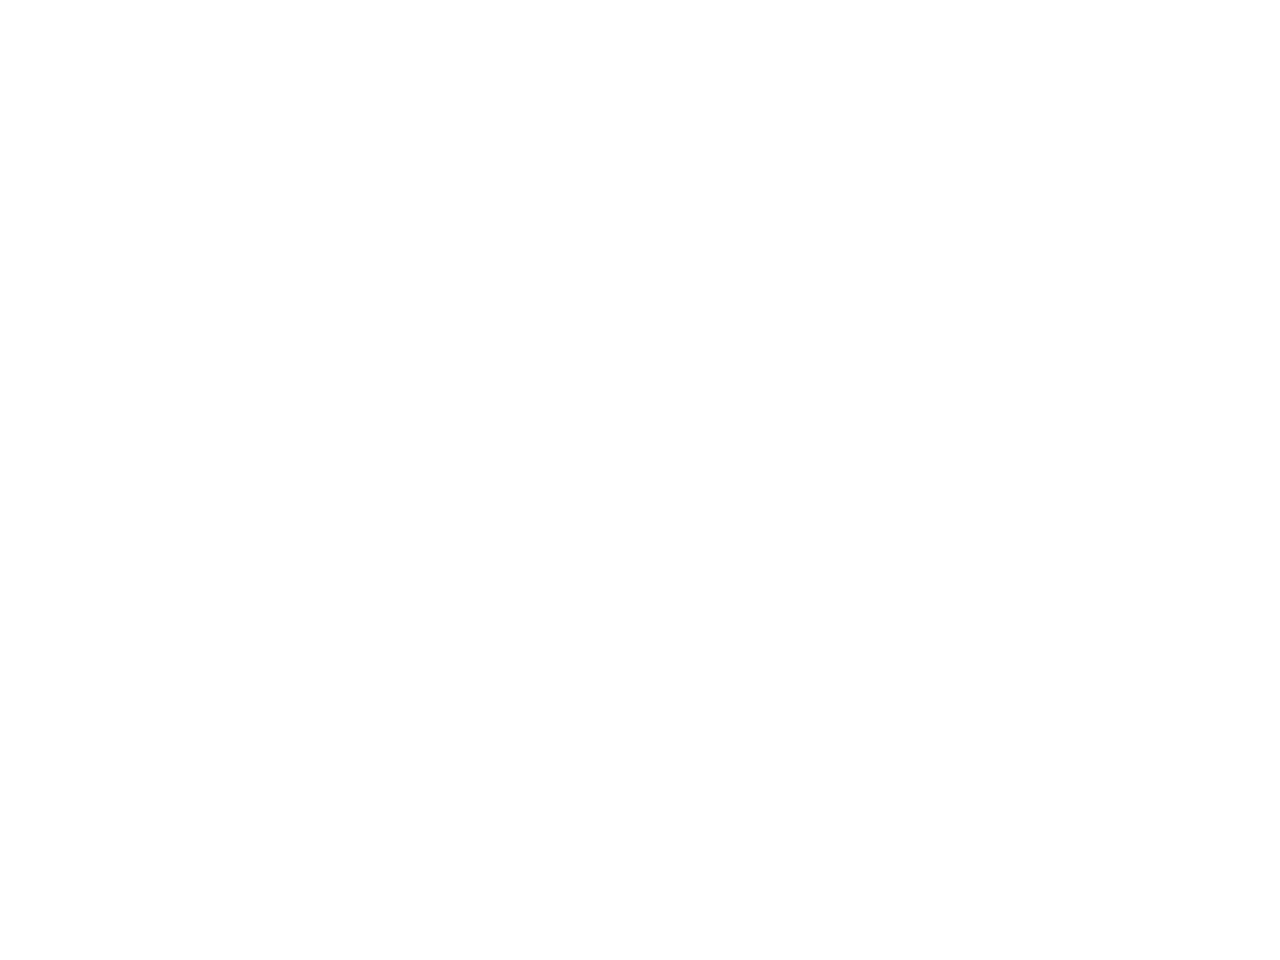

In [102]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
y, x = np.array(central_positions).T
z = all_theta
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, zdir='z', s=20, c=None, depthshade=True)
ax.set_xlabel('Pixel x')
ax.set_ylabel('Pixel y')
ax.set_zlabel('Rotation angle')
plt.show()

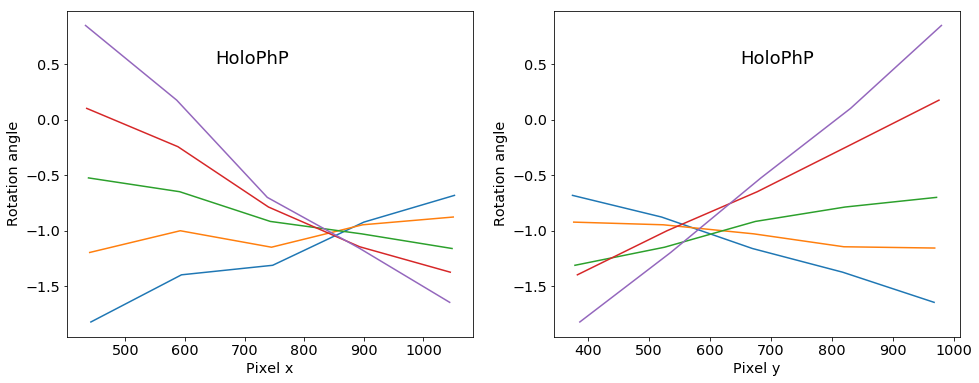

In [103]:
% matplotlib inline
def ThetaLines(all_angles,central_positions,centers=None):
    proj_x_lines = []
    f, axarr = plt.subplots(1,2,figsize=(16,6))
    for i in range(5):
        x = []
        y = []
        for it,t in enumerate(all_theta):
            if it / 5 == i : 
                x.append(central_positions[it][1])
                y.append(t)
        proj_x_lines.append([x,y])
        axarr[0].plot(x,y)
    axarr[0].set_xlabel('Pixel x')
    axarr[0].set_ylabel('Rotation angle')
    axarr[0].text(650,0.5,holo_name,fontsize=18)
    proj_y_lines = []
    for i in reversed(range(5)):
        x = []
        y = []
        for it,t in enumerate(all_theta):
            if it % 5 == i : 
                x.append(central_positions[it][0])
                y.append(t)
        proj_y_lines.append([x,y])
        axarr[1].plot(x,y)
    axarr[1].set_xlabel('Pixel y')
    axarr[1].set_ylabel('Rotation angle')
    if centers is not None :
        axarr[0].scatter(centers[0][0],centers[0][1],s=200,color='red')
        axarr[1].scatter(centers[1][0],centers[1][1],s=200,color='red')
    axarr[1].text(650,0.5,holo_name,fontsize=18)
    plt.show()
    return(proj_x_lines,proj_y_lines)

proj_x_lines, proj_y_lines = ThetaLines(all_theta,central_positions)

In [104]:
% matplotlib inline
from scipy import optimize

def dist2line(x,theta,x_line,y_line):
    t = np.interp(x,x_line,y_line)
    return(np.abs(t-theta))

def dist2lines(x,theta,lines):
    dist = 0
    for l in lines :
        x_line = l[0]
        y_line = l[1]
        dist += dist2line(x,theta,x_line,y_line)
    return(dist)

def FindHoloCenter(all_angles,central_positions,all_titles,object_name):
    """
    FindHoloCenter
    =============
    
    input:
    ------
    all_angles:
    
    
    output:
    ------
    hologram center
    
    """
    theta_max = np.max(all_angles)
    theta_min = np.min(all_angles)
    x_min = np.min(central_positions.T[1])
    x_max = np.max(central_positions.T[1])
    y_min = np.min(central_positions.T[0])
    y_max = np.max(central_positions.T[0])
    
    # Minimize in the x direction
    bounds=[[x_min,x_max],[theta_min,theta_max]]
    fun = lambda point : dist2lines(point[0],point[1],proj_x_lines)
    res = optimize.minimize(fun,(800,-1), method='SLSQP',bounds=bounds)
    x_center = res.x[0]
    theta0 = res.x[1]
    # Minimize in the y direction
    bounds=[[y_min,y_max],[theta_min,theta_max]]
    fun = lambda point : dist2lines(point[0],point[1],proj_y_lines)
    res = optimize.minimize(fun,(800,-1), method='SLSQP',bounds=bounds)
    y_center = res.x[0]
    theta0 = (theta0+res.x[1])/2.
    print 'Hologram center at x0 = %.1f and y0 = %.1f with average tilt of %.1f degrees' % (x_center,y_center,theta0)
    
    return(x_center,y_center,theta0)

Hologram center at x0 = 844.9 and y0 = 581.1 with average tilt of -1.0 degrees


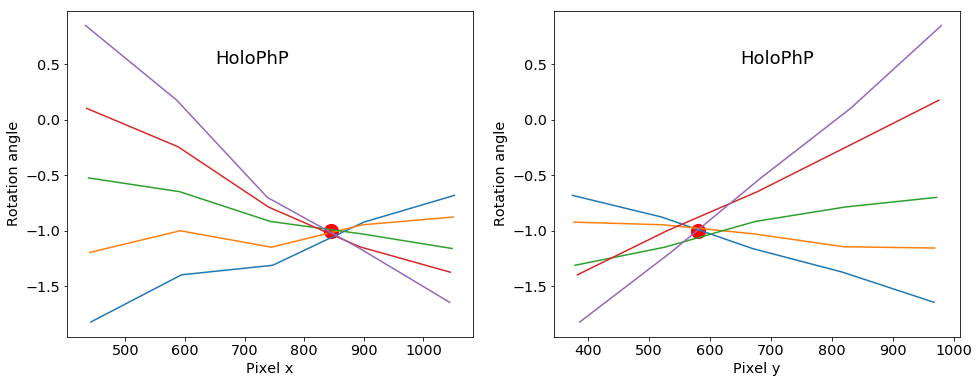

In [105]:
x_center, y_center, theta0 = FindHoloCenter(all_theta,central_positions,all_titles,object_name)
proj_x_lines, proj_y_lines = ThetaLines(all_theta,central_positions,centers=[[x_center,theta0],[y_center,theta0]])

### prepare outputfilename

In [106]:
sorted_files

array(['cut_fitsimages/cutimg_20170529_113.fits',
       'cut_fitsimages/cutimg_20170529_114.fits',
       'cut_fitsimages/cutimg_20170529_115.fits',
       'cut_fitsimages/cutimg_20170529_116.fits',
       'cut_fitsimages/cutimg_20170529_117.fits',
       'cut_fitsimages/cutimg_20170529_118.fits',
       'cut_fitsimages/cutimg_20170529_119.fits',
       'cut_fitsimages/cutimg_20170529_120.fits',
       'cut_fitsimages/cutimg_20170529_121.fits',
       'cut_fitsimages/cutimg_20170529_122.fits',
       'cut_fitsimages/cutimg_20170529_123.fits',
       'cut_fitsimages/cutimg_20170529_124.fits',
       'cut_fitsimages/cutimg_20170529_125.fits',
       'cut_fitsimages/cutimg_20170529_126.fits',
       'cut_fitsimages/cutimg_20170529_127.fits',
       'cut_fitsimages/cutimg_20170529_128.fits',
       'cut_fitsimages/cutimg_20170529_129.fits',
       'cut_fitsimages/cutimg_20170529_130.fits',
       'cut_fitsimages/cutimg_20170529_131.fits',
       'cut_fitsimages/cutimg_20170529_132.fits',


In [107]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    short_infilename=file.split("/")[1]
    short_partfilename=re.findall('^cutimg_(.*)',short_infilename)
    short_outfilename='rotimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [108]:
newfullfilenames

['./rotated_fitsimages/rotimg_20170529_113.fits',
 './rotated_fitsimages/rotimg_20170529_114.fits',
 './rotated_fitsimages/rotimg_20170529_115.fits',
 './rotated_fitsimages/rotimg_20170529_116.fits',
 './rotated_fitsimages/rotimg_20170529_117.fits',
 './rotated_fitsimages/rotimg_20170529_118.fits',
 './rotated_fitsimages/rotimg_20170529_119.fits',
 './rotated_fitsimages/rotimg_20170529_120.fits',
 './rotated_fitsimages/rotimg_20170529_121.fits',
 './rotated_fitsimages/rotimg_20170529_122.fits',
 './rotated_fitsimages/rotimg_20170529_123.fits',
 './rotated_fitsimages/rotimg_20170529_124.fits',
 './rotated_fitsimages/rotimg_20170529_125.fits',
 './rotated_fitsimages/rotimg_20170529_126.fits',
 './rotated_fitsimages/rotimg_20170529_127.fits',
 './rotated_fitsimages/rotimg_20170529_128.fits',
 './rotated_fitsimages/rotimg_20170529_129.fits',
 './rotated_fitsimages/rotimg_20170529_130.fits',
 './rotated_fitsimages/rotimg_20170529_131.fits',
 './rotated_fitsimages/rotimg_20170529_132.fits',


### Save outputfilename

In [109]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=turned_images[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [110]:
!ls -l rotated_fitsimages

total 349008
-rw-r--r--  1 jneveu  staff  7675200  1 jui 10:42 rotimg_20170529_113.fits
-rw-r--r--  1 jneveu  staff  7418880  1 jui 10:42 rotimg_20170529_114.fits
-rw-r--r--  1 jneveu  staff  7369920  1 jui 10:42 rotimg_20170529_115.fits
-rw-r--r--  1 jneveu  staff  7128000  1 jui 10:42 rotimg_20170529_116.fits
-rw-r--r--  1 jneveu  staff  6975360  1 jui 10:42 rotimg_20170529_117.fits
-rw-r--r--  1 jneveu  staff  7300800  1 jui 10:42 rotimg_20170529_118.fits
-rw-r--r--  1 jneveu  staff  7179840  1 jui 10:42 rotimg_20170529_119.fits
-rw-r--r--  1 jneveu  staff  7266240  1 jui 10:42 rotimg_20170529_120.fits
-rw-r--r--  1 jneveu  staff  7145280  1 jui 10:42 rotimg_20170529_121.fits
-rw-r--r--  1 jneveu  staff  7096320  1 jui 10:42 rotimg_20170529_122.fits
-rw-r--r--  1 jneveu  staff  6891840  1 jui 10:42 rotimg_20170529_123.fits
-rw-r--r--  1 jneveu  staff  6958080  1 jui 10:42 rotimg_20170529_124.fits
-rw-r--r--  1 jneveu  staff  7128000  1 jui 10:42 rotimg_20170529_125.fits
-rw-r--r--  